# Deep Learning for Predictive Maintenance

This is the skeleton code file for the EEC4400 assignment. Replace the XX in the name of this notebook with your group number (this is important for correct marks to be awarded to your group). Fill in the blank cells below with the necessary code (you should work on this notebook section by section). At the end, the entire notebook should generate all the required results and execute without error.

The text above the blank cells provide some information on the functionality that needs to be implemented. You need to write Python code at places indicated by "[WriteCode]".

In this notebook, we explore the following:

1. CNN 1D and LSTM models
2. Two types of prediction tasks
  
  a. Binary Classification :  determining if a machine will fail in a given "w1" window period (Yes/No)

  b. Regression : predicting the remaining time a machine can run before failing (RUL)


In [131]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from tensorflow import keras  # make sure you use TensorFlow Keras
import seaborn as sns
import warnings
import os
import time
%matplotlib inline

from sklearn import preprocessing

# Extra imports must be done by students
# [WriteCode] from ... import ...
# [WriteCode] from ... import ...
# [WriteCode] from ... import ...
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from tensorflow.keras.callbacks import EarlyStopping
import keras
from keras.callbacks import TensorBoard, EarlyStopping
import tensorflow as tf
#from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# Setting seed for reproducibility (uncomment and use if needed)
# np.random.seed(xx)  
# PYTHONHASHSEED = x

## Setting up TensorBoard

In [132]:
def get_run_logdir(k):
    root_logdir = os.path.join(os.curdir, "eec4400_logs", k)
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

## Initialize model parameters

Use the form below to enter parameter values before re-running the notebook. 

Use the same no. of epochs (ep) and batch size (ba) values for all the baseline CNN-Bin, LSTM-Bin, CNN-RUL and LSTM-RUL models.

Create additional variables and fields in this form as you require.

In [133]:
# Input Parameters
sequence_length = 25  # length of each sequence of values
ep = 5  # epochs
ba = 100  # batch_size

In [134]:
# DO NOT CHANGE the settings in this cell
w1 = 30  # window size before failure classification

## Data Ingestion
In the following section, 
- We ingest the training, test and ground truth datasets
- We provide column headings for consistency

(*Note*: training, test and ground truth dataframes are named "train_df", "test_df", and "truth_df" correspondingly. This naming is used consistently throughout the skeleton file.)

In [135]:
# Data ingestion

# read training data 
train_df = pd.read_csv('PM_train-2024.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                    's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                    's15', 's16', 's17', 's18', 's19', 's20', 's21']

# read test data
test_df = pd.read_csv('PM_test-2024.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                   's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                   's15', 's16', 's17', 's18', 's19', 's20', 's21']

# read ground truth data
truth_df = pd.read_csv('PM_truth-2024.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)

# final Training data
train_df = train_df.sort_values(['id', 'cycle'])
train_df.head()

id  cycle  setting1  setting2  setting3      s1      s2       s3       s4  \
0   1      1   -0.0005    0.0004     100.0  518.67  642.36  1583.23  1396.84   
1   1      2    0.0008   -0.0003     100.0  518.67  642.50  1584.69  1396.89   
2   1      3   -0.0014   -0.0002     100.0  518.67  642.18  1582.35  1405.61   
3   1      4   -0.0020    0.0001     100.0  518.67  642.92  1585.61  1392.27   
4   1      5    0.0016    0.0000     100.0  518.67  641.68  1588.63  1397.65   

      s5  ...     s12      s13      s14     s15   s16  s17   s18    s19  \
0  14.62  ...  522.31  2388.01  8145.32  8.4246  0.03  391  2388  100.0   
1  14.62  ...  522.42  2388.03  8152.85  8.4403  0.03  392  2388  100.0   
2  14.62  ...  522.03  2388.00  8150.17  8.3901  0.03  391  2388  100.0   
3  14.62  ...  522.49  2388.08  8146.56  8.3878  0.03  392  2388  100.0   
4  14.62  ...  522.58  2388.03  8147.80  8.3869  0.03  392  2388  100.0   

     s20      s21  
0  39.11  23.3537  
1  38.99  23.4491  
2  38.85  23.3669  
3  38.96  23.2951  
4  39.14  23.4583  

[5 rows x 26 columns]

## Data Exploration

Understanding the underlying characteristics of the dataset:
- Plot cross-correlation heatmap to understand correlation between sensor readings in training data (use seaborn package)
- Observe the data characteristics of three machines with shortest, average and longest operating lifetime (code provided)

(*Note*: use the results to answer the Data Exploration question Section 7 of the assignment document)

### Cross-correlation Heatmap

Expected result:

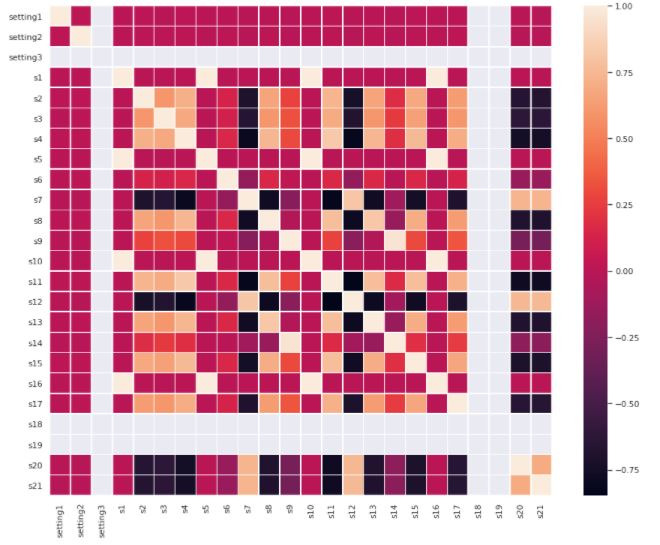

In [136]:
# Cross-correlation HeatMap

sns.set()


def labels(x, y, *axes):
    for axis in axes:
        if x: axis.set_xlabel(x)
        if y: axis.set_ylabel(y)


df_sub = train_df.copy()
del df_sub['id']

df_sub.set_index('cycle', inplace=True)

# [WriteCode] to determine Pearson correlation and save in dataframe df_corr
df_corr = df_sub.corr(method='pearson')

In [137]:
df_corr

setting1  setting2  setting3  s1        s2        s3        s4  s5  \
setting1  1.000000  0.001226       NaN NaN -0.002098 -0.004154  0.000811 NaN   
setting2  0.001226  1.000000       NaN NaN  0.005117  0.005186  0.004128 NaN   
setting3       NaN       NaN       NaN NaN       NaN       NaN       NaN NaN   
s1             NaN       NaN       NaN NaN       NaN       NaN       NaN NaN   
s2       -0.002098  0.005117       NaN NaN  1.000000  0.640503  0.745167 NaN   
s3       -0.004154  0.005186       NaN NaN  0.640503  1.000000  0.716890 NaN   
s4        0.000811  0.004128       NaN NaN  0.745167  0.716890  1.000000 NaN   
s5             NaN       NaN       NaN NaN       NaN       NaN       NaN NaN   
s6       -0.000051 -0.006029       NaN NaN  0.314799  0.269463  0.319139 NaN   
s7       -0.002498 -0.002446       NaN NaN  0.124167  0.282007  0.181976 NaN   
s8       -0.001344  0.000628       NaN NaN  0.533915  0.637926  0.601272 NaN   
s9       -0.007728  0.012311       NaN NaN  0.441283  0.535074  0.509782 NaN   
s10      -0.005541 -0.002698       NaN NaN  0.256388  0.367705  0.330834 NaN   
s11      -0.003287  0.002195       NaN NaN  0.762269  0.746093  0.854030 NaN   
s12      -0.003288 -0.001333       NaN NaN  0.141785  0.298941  0.202106 NaN   
s13      -0.002467 -0.001413       NaN NaN  0.532745  0.636513  0.601254 NaN   
s14      -0.008939  0.015843       NaN NaN  0.343954  0.454205  0.404686 NaN   
s15       0.007104  0.002108       NaN NaN  0.232947  0.076820  0.216773 NaN   
s16            NaN       NaN       NaN NaN       NaN       NaN       NaN NaN   
s17       0.001679  0.003078       NaN NaN  0.670062  0.677216  0.749907 NaN   
s18            NaN       NaN       NaN NaN       NaN       NaN       NaN NaN   
s19            NaN       NaN       NaN NaN       NaN       NaN       NaN NaN   
s20      -0.005606 -0.001032       NaN NaN -0.246286 -0.091851 -0.235016 NaN   
s21      -0.001452 -0.003564       NaN NaN -0.241318 -0.089035 -0.230134 NaN   

                s6        s7  ...       s12       s13       s14       s15  \
setting1 -0.000051 -0.002498  ... -0.003288 -0.002467 -0.008939  0.007104   
setting2 -0.006029 -0.002446  ... -0.001333 -0.001413  0.015843  0.002108   
setting3       NaN       NaN  ...       NaN       NaN       NaN       NaN   
s1             NaN       NaN  ...       NaN       NaN       NaN       NaN   
s2        0.314799  0.124167  ...  0.141785  0.532745  0.343954  0.232947   
s3        0.269463  0.282007  ...  0.298941  0.636513  0.454205  0.076820   
s4        0.319139  0.181976  ...  0.202106  0.601254  0.404686  0.216773   
s5             NaN       NaN  ...       NaN       NaN       NaN       NaN   
s6        1.000000 -0.208690  ... -0.200906  0.247099  0.008579  0.485677   
s7       -0.208690  1.000000  ...  0.988725  0.597169  0.601013 -0.826574   
s8        0.247480  0.596510  ...  0.608298  0.964052  0.519624 -0.238368   
s9        0.065131  0.579004  ...  0.590891  0.578325  0.954354 -0.287941   
s10      -0.184268  0.830550  ...  0.836185  0.547460  0.555604 -0.631628   
s11       0.305777  0.270774  ...  0.290664  0.659375  0.441050  0.144079   
s12      -0.200906  0.988725  ...  1.000000  0.608714  0.610383 -0.819711   
s13       0.247099  0.597169  ...  0.608714  1.000000  0.519054 -0.238863   
s14       0.008579  0.601013  ...  0.610383  0.519054  1.000000 -0.357095   
s15       0.485677 -0.826574  ... -0.819711 -0.238863 -0.357095  1.000000   
s16            NaN       NaN  ...       NaN       NaN       NaN       NaN   
s17       0.285658  0.285796  ...  0.303758  0.663126  0.471264  0.091125   
s18            NaN       NaN  ...       NaN       NaN       NaN       NaN   
s19            NaN       NaN  ...       NaN       NaN       NaN       NaN   
s20      -0.345912  0.802838  ...  0.794781  0.243193  0.332629 -0.849881   
s21      -0.347739  0.807138  ...  0.800166  0.245326  0.339979 -0.852349   

          s16       s17  s18  s19       s20       s21  
setting1  NaN  0.001679  Na

Text(0.5, 1.0, 'Pearson Correlation Heatmap')

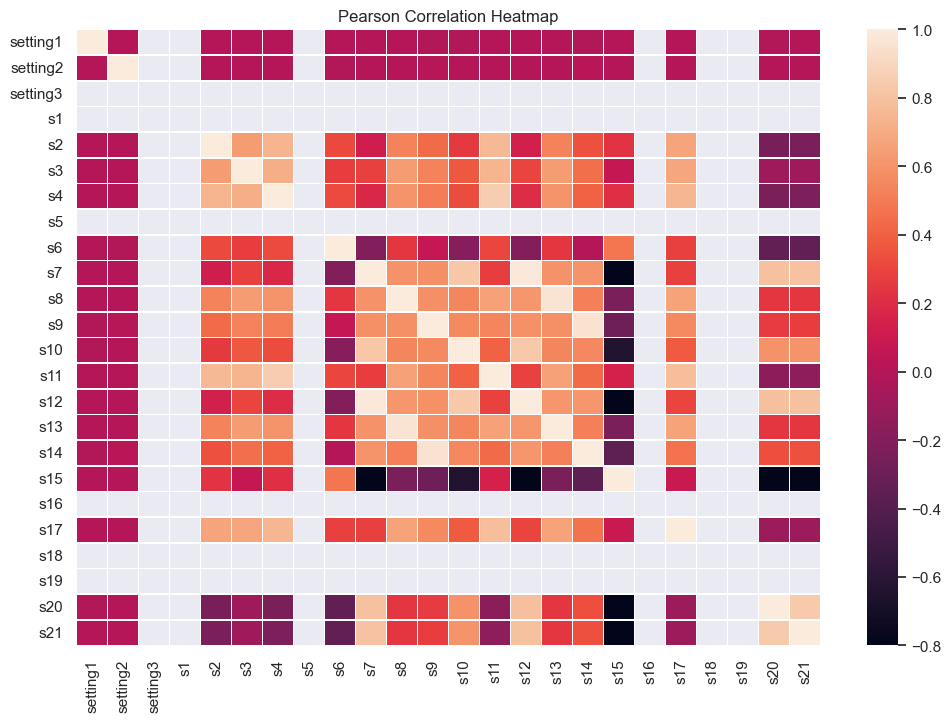

In [138]:
# [WriteCode] for plotting cross-correlation heatmap using seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(df_corr, vmin=-0.80, vmax=1, linewidths=0.5, linecolor='white')

# Add labels to the axes
#labels(list(train_df.columns), list(test_df.columns), plt.gca())

# Show the plot
plt.title('Pearson Correlation Heatmap')


In [139]:
train_df

id  cycle  setting1  setting2  setting3      s1      s2       s3  \
0        1      1   -0.0005    0.0004     100.0  518.67  642.36  1583.23   
1        1      2    0.0008   -0.0003     100.0  518.67  642.50  1584.69   
2        1      3   -0.0014   -0.0002     100.0  518.67  642.18  1582.35   
3        1      4   -0.0020    0.0001     100.0  518.67  642.92  1585.61   
4        1      5    0.0016    0.0000     100.0  518.67  641.68  1588.63   
...    ...    ...       ...       ...       ...     ...     ...      ...   
24715  100    148   -0.0016   -0.0003     100.0  518.67  643.78  1596.01   
24716  100    149    0.0034   -0.0003     100.0  518.67  643.29  1596.38   
24717  100    150   -0.0016    0.0004     100.0  518.67  643.84  1604.53   
24718  100    151   -0.0023    0.0004     100.0  518.67  643.94  1597.56   
24719  100    152    0.0000    0.0003     100.0  518.67  643.64  1599.04   

            s4     s5  ...     s12      s13      s14     s15   s16  s17   s18  \
0      1396.84  14.62  ...  522.31  2388.01  8145.32  8.4246  0.03  391  2388   
1      1396.89  14.62  ...  522.42  2388.03  8152.85  8.4403  0.03  392  2388   
2      1405.61  14.62  ...  522.03  2388.00  8150.17  8.3901  0.03  391  2388   
3      1392.27  14.62  ...  522.49  2388.08  8146.56  8.3878  0.03  392  2388   
4      1397.65  14.62  ...  522.58  2388.03  8147.80  8.3869  0.03  392  2388   
...        ...    ...  ...     ...      ...      ...     ...   ...  ...   ...   
24715  1424.11  14.62  ...  519.66  2388.30  8138.08  8.5036  0.03  394  2388   
24716  1429.14  14.62  ...  519.91  2388.28  8144.36  8.5174  0.03  395  2388   
24717  1431.41  14.62  ...  519.44  2388.24  8135.95  8.5223  0.03  396  2388   
24718  1426.57  14.62  ...  520.01  2388.26  8141.24  8.5148  0.03  395  2388   
24719  1436.06  14.62  ...  519.48  2388.24  8136.98  8.5150  0.03  396  2388   

         s19    s20      s21  
0      100.0  39.11  23.3537  
1      100.0  38.99  23.4491  
2      100.0  38.85  23.3669  
3      100.0  38.96  23.2951  
4      100.0  39.14  23.4583  
...      ...    ...      ...  
24715  100.0  38.44  22.9631  
24716  100.0  38.50  22.9746  
24717  100.0  38.39  23.0682  
24718  100.0  38.31  23.0753  
24719  100.0  38.56  23.0847  

[24720 rows x 26 columns]

### Shortest, Average and Longest machine lifetimes

In [140]:
# Some Plotting Functions

mapp = {}
for id_num in train_df['id'].unique():
    mapp[id_num] = train_df['cycle'].loc[train_df['id'] == id_num].max()
mapp_len = sorted(mapp.items(), key=lambda kv: kv[1])
wind_size = w1

#Filter out "meaningful" columns from a given DataFrame (df_sub) (i.e., columns that don't contain id and RUL columns, and contain at least 3 different values)
def exclude_trivial(df_sub):
    cols = []
    for col in df_sub.columns:
        if col == 'id':
            continue
        elif col == 'RUL':
            continue
        elif len(df_sub[col].unique()) <= 2:
            continue
        else:
            cols.append(col)
    return df_sub[cols].copy()


#Data related to a specific device (or unit) is extracted and cleaned before returning.
def get_data_non_trivial(df, unit_num, ):
    df_sub = df.loc[df['id'] == unit_num].copy()
    df_sub.set_index('cycle', inplace=True)
    df_sub.dropna(axis=1, how='all', inplace=True)
    df_sub = exclude_trivial(df_sub)
    return df_sub


#Get specific columns
def get_data_by_cols_and_unit(df, unit_num, cols):
    df_sub = df.loc[df['id'] == unit_num].copy()
    df_sub.set_index('cycle', inplace=True)
    df_sub.dropna(axis=1, how='all', inplace=True)
    df_sub = df_sub[cols]
    return df_sub


#Time series data is plotted to show how each nontrivial measure and state changes over time, along with moving medians and moving averages.
def plot_ts(df, unit_num, wind_size):
    '''plot all non trivial measurements and states'''
    df_sub = get_data_non_trivial(df, unit_num)
    cols = df_sub.columns
    fig, axes = plt.subplots(len(cols), 1, figsize=(15, 12))
    for col, ax in zip(cols, axes):
        df_sub[col].plot(ax=ax)
        df_sub[col].rolling(wind_size).median().plot(ax=ax)
        df_sub[col].rolling(wind_size).mean().plot(style='--', legend=True, ax=ax)
    fig.suptitle('unit NUM: {}'.format(unit_num))


#Plot a histogram of non-trivial measurements and states in a DataFrame.
def plot_hist(df, unit_num, wind_size):
    '''plot all non trivial measurements and states'''
    df_sub = get_data_non_trivial(df, unit_num)
    cols = df_sub.columns
    n_cols = min(len(cols), 5)
    n_rows = int(np.ceil(len(cols) / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 12))
    axes = axes.flatten()
    for col, ax in zip(cols, axes):
        sns.distplot(df_sub[[col]], ax=ax, label=col)
        labels(col, "p", ax)
    fig.suptitle('unit NUM: {}'.format(unit_num))


def plot_learn(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.ylim((0, 0.1))
    plt.xlim((1, ep))
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

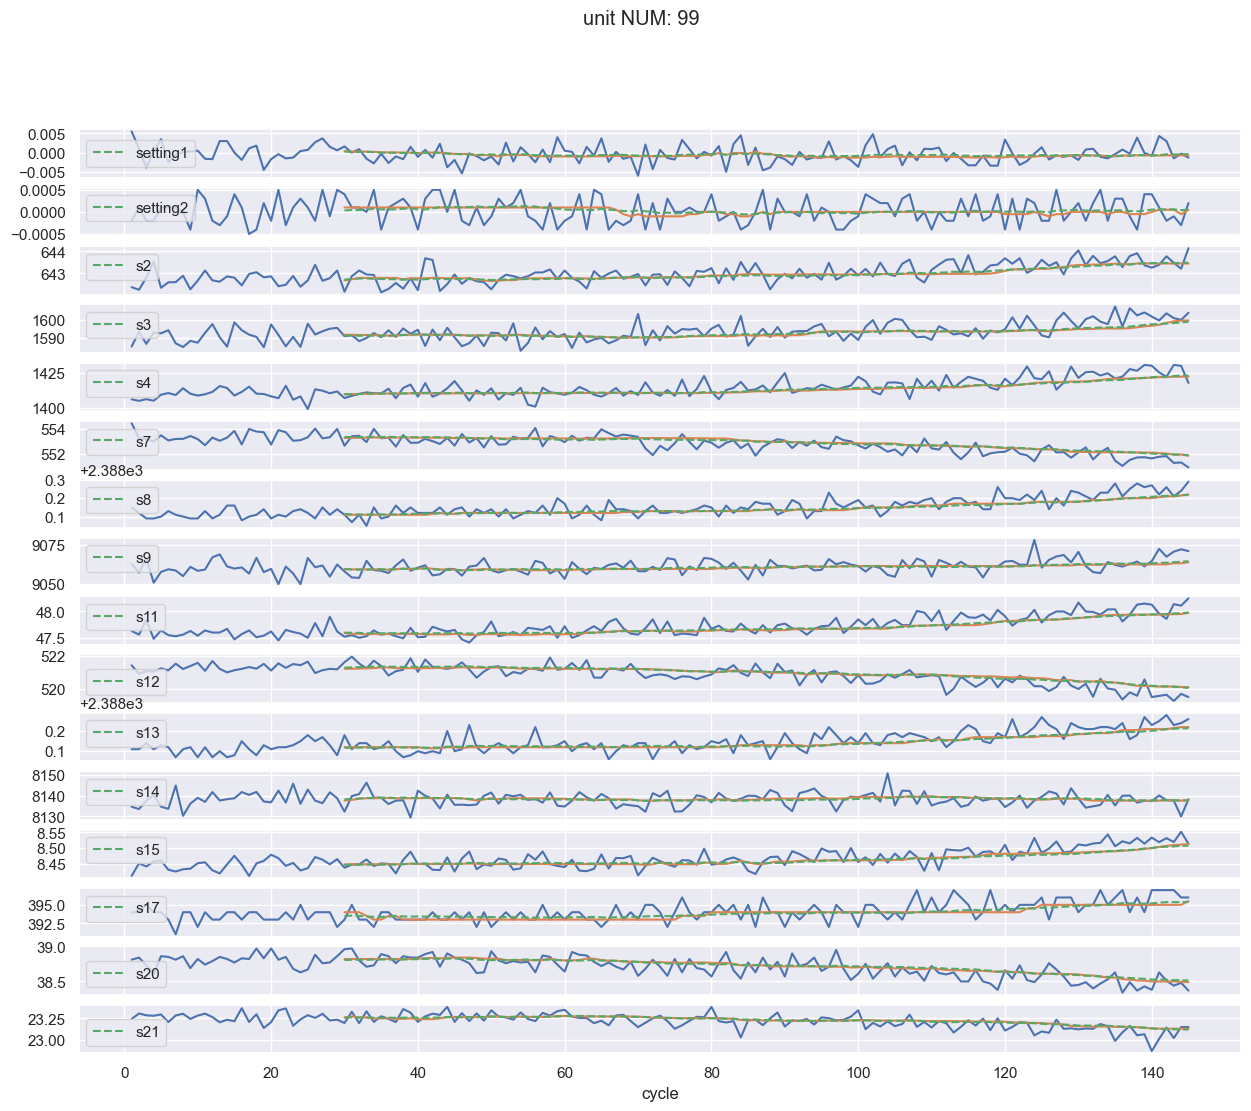

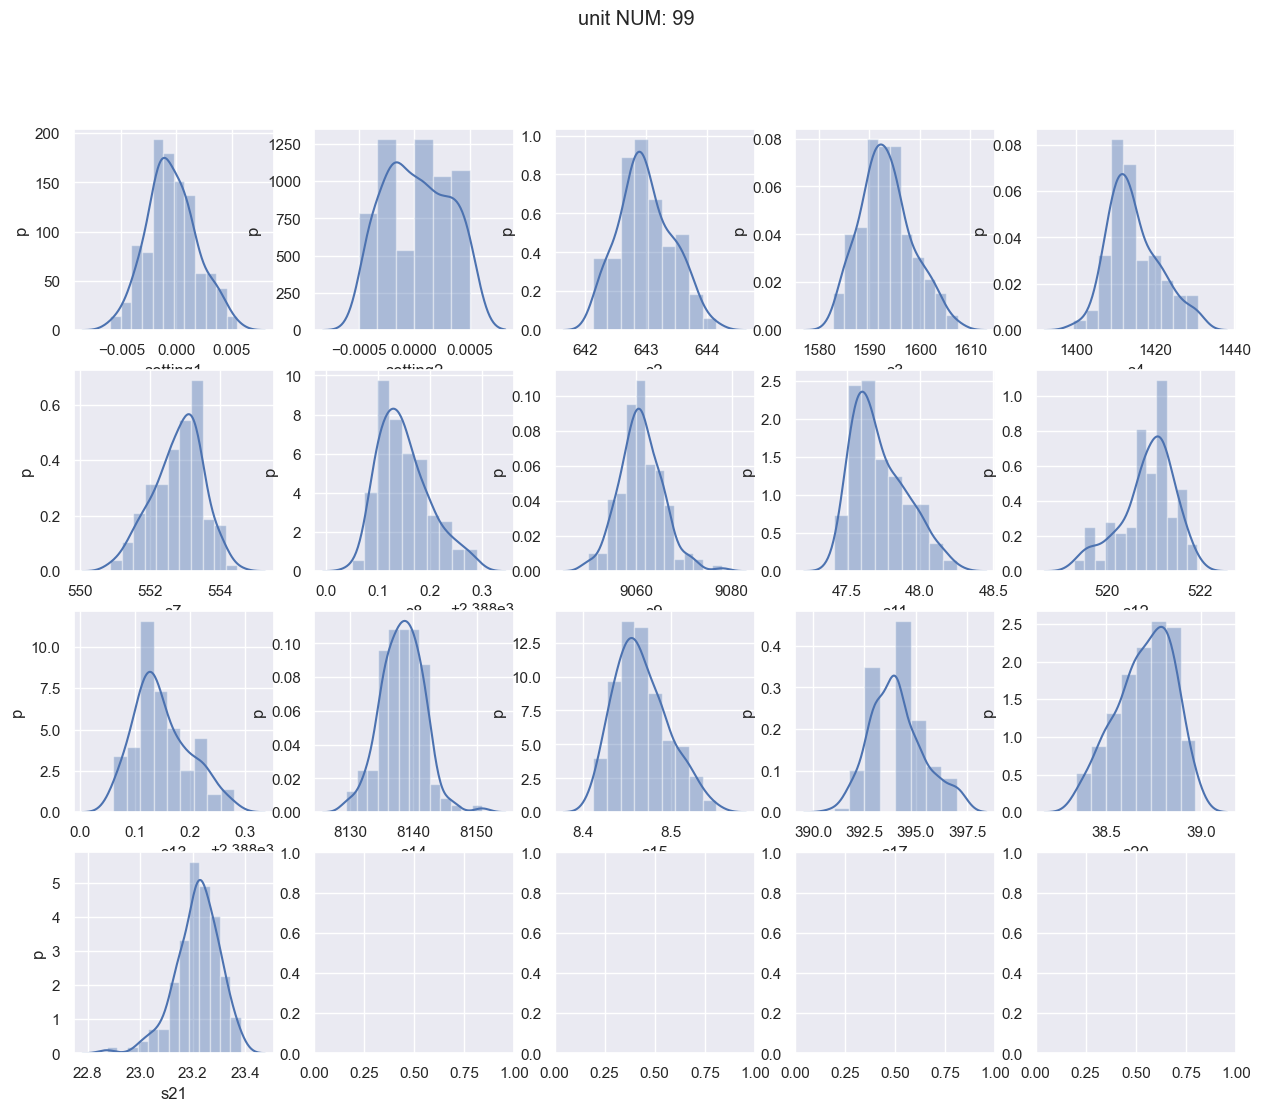

In [141]:
# Plotting sensor readings and distribution of sensor readings for machines with shortest, medium and longest operating times
warnings.filterwarnings('ignore')

# plot shortest operating time machine data
unit_to_plt = mapp_len[0][0]
plot_ts(train_df, unit_to_plt, wind_size)
plot_hist(train_df, unit_to_plt, wind_size)

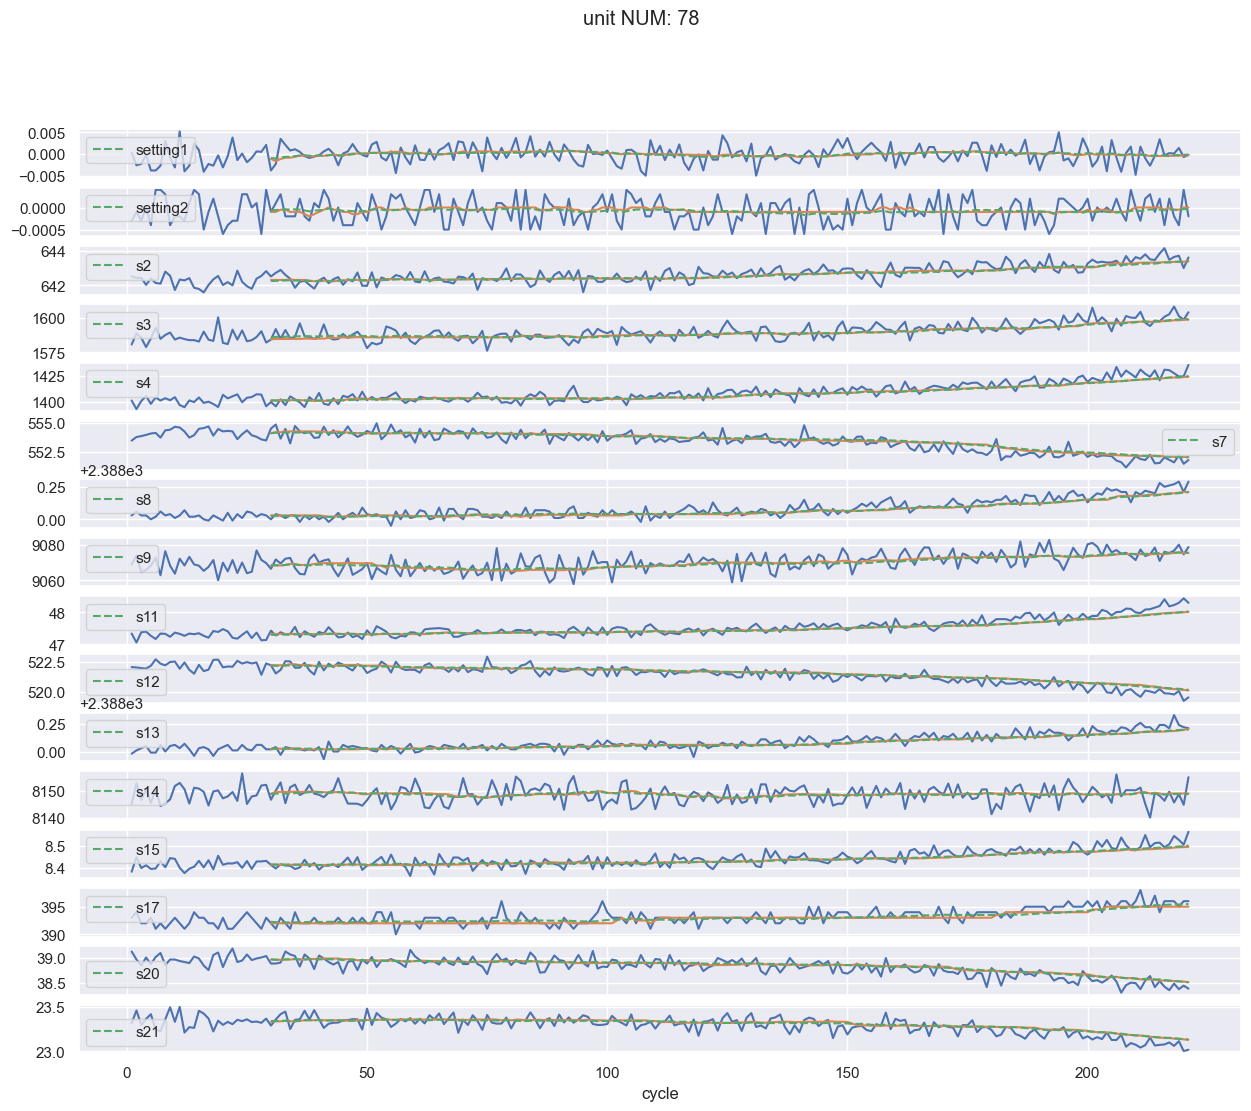

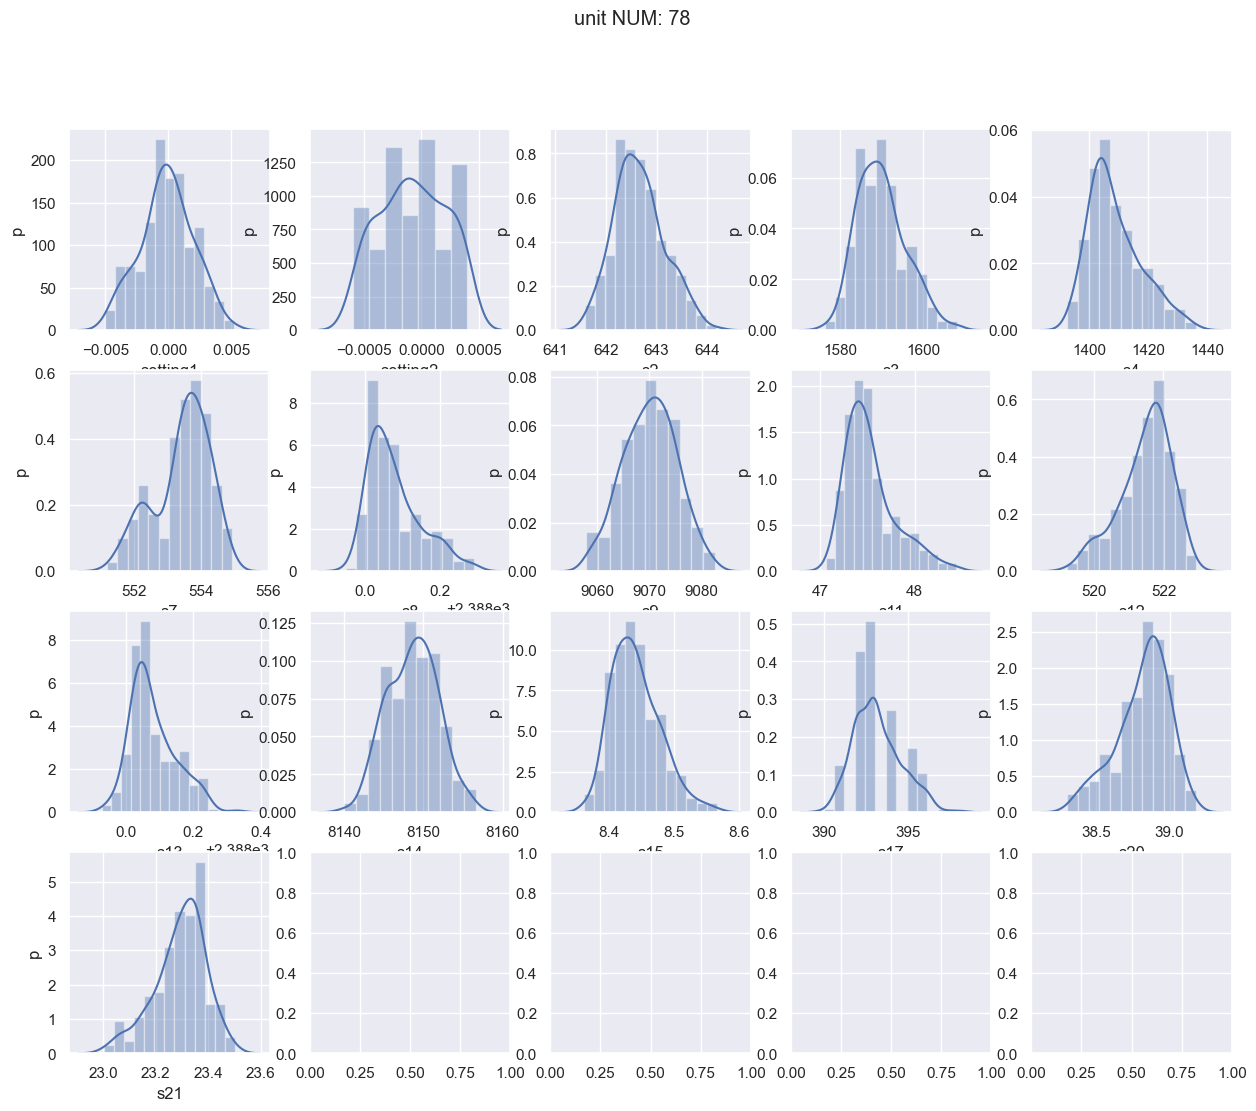

In [142]:
# plot medium operating time machine data
unit_to_plt = mapp_len[int(len(mapp) / 2)][0]
plot_ts(train_df, unit_to_plt, wind_size)
plot_hist(train_df, unit_to_plt, wind_size)

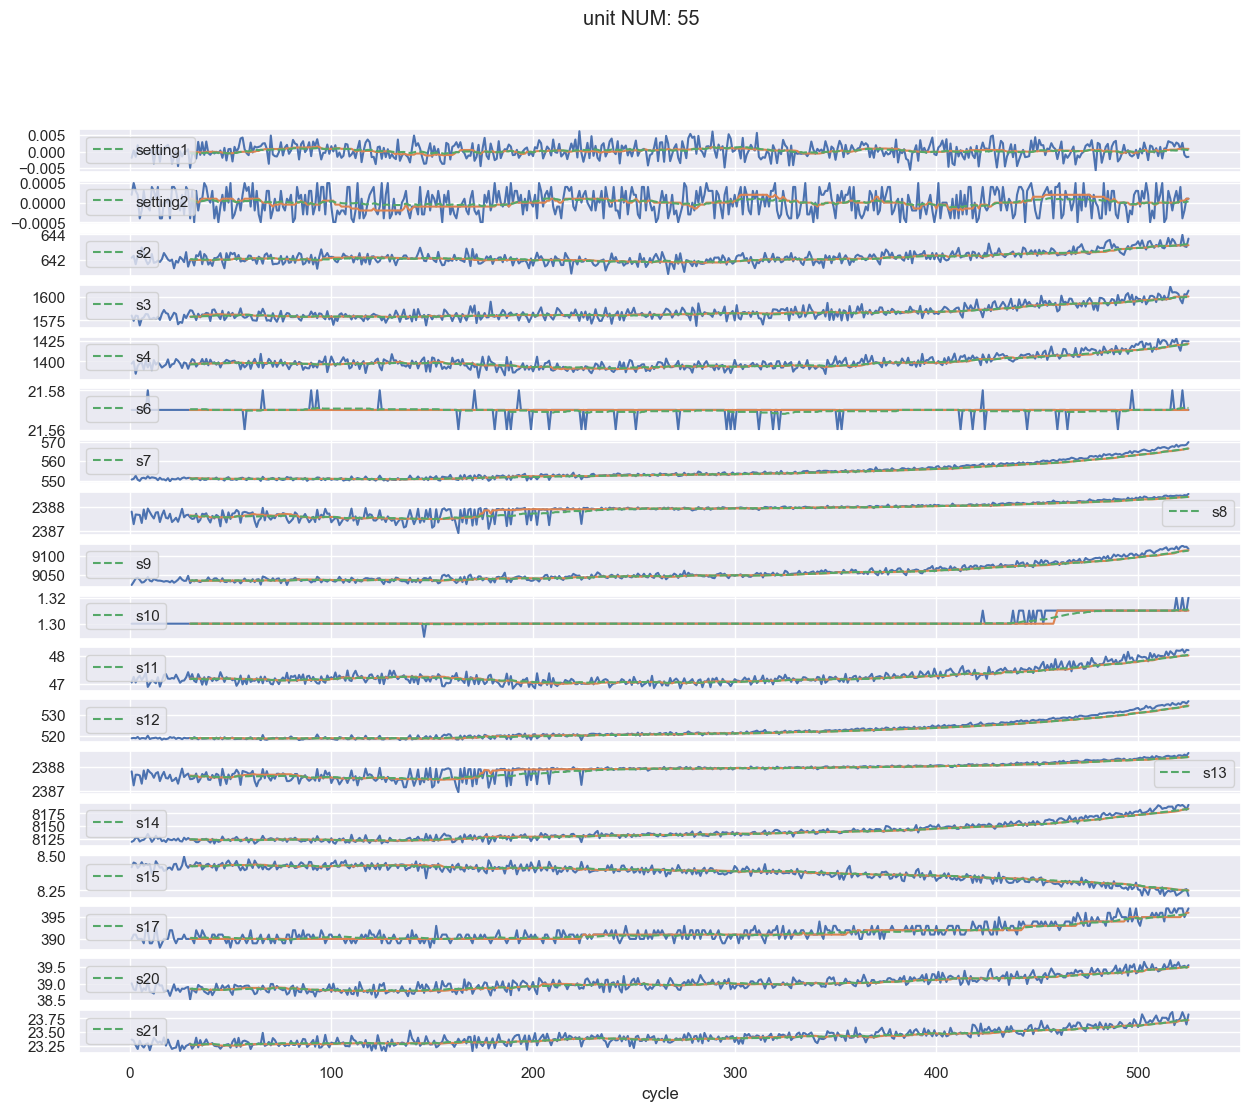

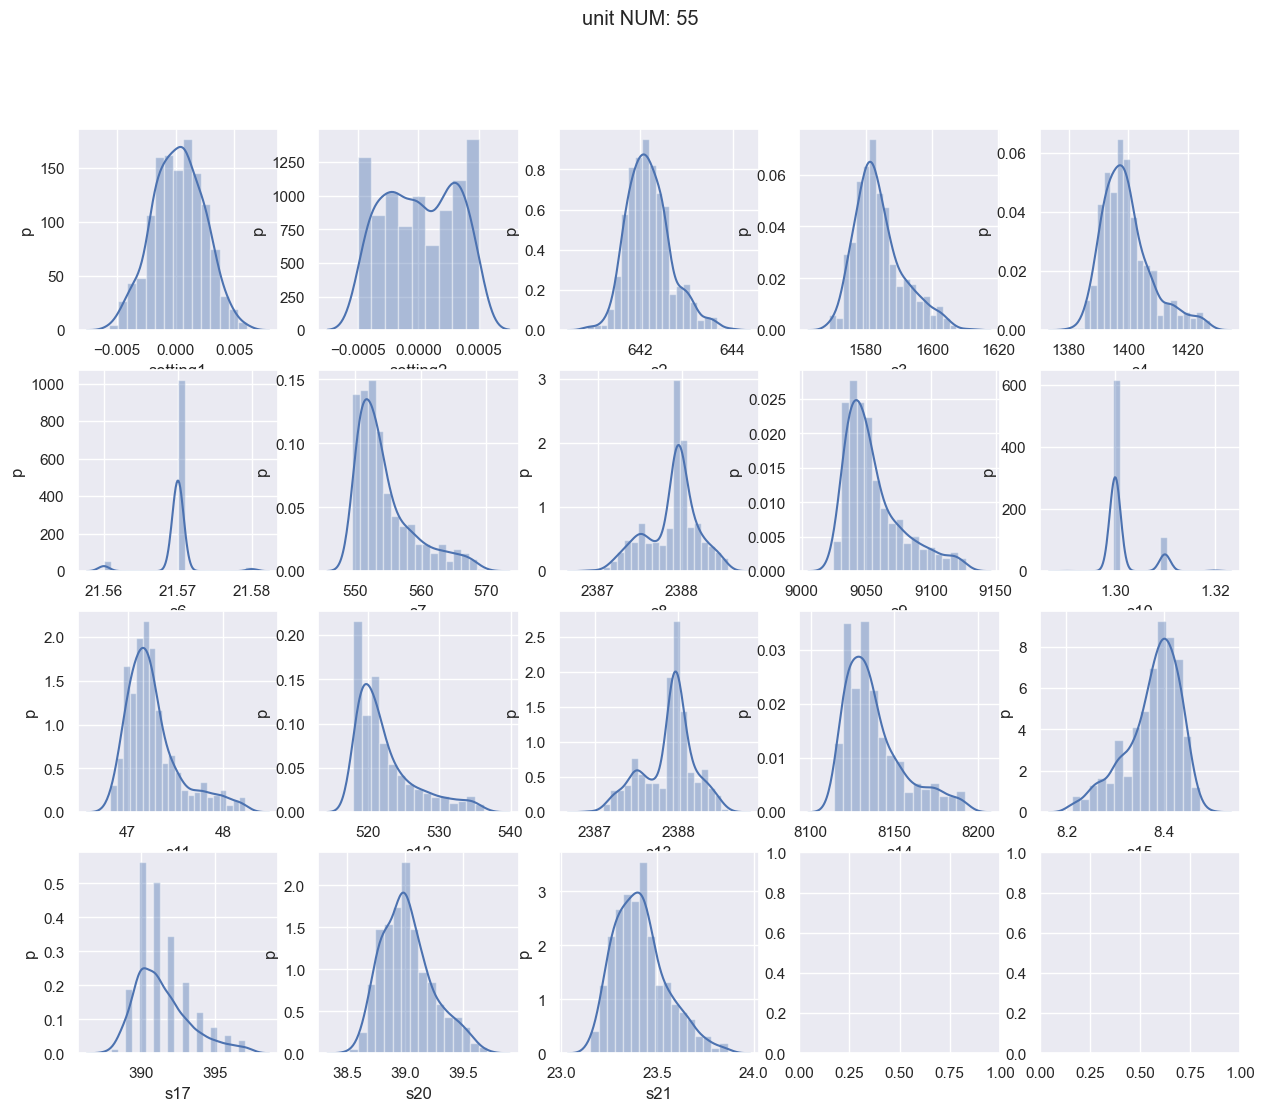

In [143]:
# plot longest operating time machine data
unit_to_plt = mapp_len[-1][0]
plot_ts(train_df, unit_to_plt, wind_size)
plot_hist(train_df, unit_to_plt, wind_size)

warnings.filterwarnings('default')

## Data Preprocessing


### Data Labeling

Generating labels for the training data for both prediction tasks:
- Remaining Useful Life ("RUL") for regression task
- "label1" for binary classification (to answer the question: is a specific engine going to fail within "w1" cycles?)

Columns "RUL" and "label1" are created

(*Note*: Column names are case-sensitive and this section is already coded.)

In [144]:
# Data Labeling for training data - generate column RUL

rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)

# generate label1 column for training data
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0)
train_df.head()

id  cycle  setting1  setting2  setting3      s1      s2       s3       s4  \
0   1      1   -0.0005    0.0004     100.0  518.67  642.36  1583.23  1396.84   
1   1      2    0.0008   -0.0003     100.0  518.67  642.50  1584.69  1396.89   
2   1      3   -0.0014   -0.0002     100.0  518.67  642.18  1582.35  1405.61   
3   1      4   -0.0020    0.0001     100.0  518.67  642.92  1585.61  1392.27   
4   1      5    0.0016    0.0000     100.0  518.67  641.68  1588.63  1397.65   

      s5  ...      s14     s15   s16  s17   s18    s19    s20      s21  RUL  \
0  14.62  ...  8145.32  8.4246  0.03  391  2388  100.0  39.11  23.3537  258   
1  14.62  ...  8152.85  8.4403  0.03  392  2388  100.0  38.99  23.4491  257   
2  14.62  ...  8150.17  8.3901  0.03  391  2388  100.0  38.85  23.3669  256   
3  14.62  ...  8146.56  8.3878  0.03  392  2388  100.0  38.96  23.2951  255   
4  14.62  ...  8147.80  8.3869  0.03  392  2388  100.0  39.14  23.4583  254   

   label1  
0       0  
1       0  
2       0  
3       0  
4       0  

[5 rows x 28 columns]

In [145]:
# Data Labeling for test data - generate column RUL

rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)

# generate label1 column for test data
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0)
test_df.head()

id  cycle  setting1  setting2  setting3      s1      s2       s3       s4  \
0   1      1   -0.0017   -0.0004     100.0  518.67  641.94  1581.93  1396.93   
1   1      2    0.0006   -0.0002     100.0  518.67  642.02  1584.86  1398.90   
2   1      3    0.0014   -0.0003     100.0  518.67  641.68  1581.78  1391.92   
3   1      4    0.0027    0.0001     100.0  518.67  642.20  1584.53  1395.34   
4   1      5   -0.0001    0.0001     100.0  518.67  642.46  1589.03  1395.86   

      s5  ...      s14     s15   s16  s17   s18    s19    s20      s21  RUL  \
0  14.62  ...  8133.48  8.3760  0.03  391  2388  100.0  39.07  23.4468  276   
1  14.62  ...  8137.44  8.4062  0.03  391  2388  100.0  39.04  23.4807  275   
2  14.62  ...  8138.25  8.3553  0.03  391  2388  100.0  39.10  23.4244  274   
3  14.62  ...  8137.07  8.3709  0.03  392  2388  100.0  38.97  23.4782  273   
4  14.62  ...  8134.20  8.4146  0.03  391  2388  100.0  39.09  23.3950  272   

   label1  
0       0  
1       0  
2       0  
3       0  
4       0  

[5 rows x 28 columns]

In [146]:
### Data Normalization

#Perform minmax normalization using MinMax scaler in sklearn on both training and test data (train_df and test_df)

# MinMax normalization for training data

train_df['cycle_norm'] = train_df['cycle'] 

# [WriteCode]

scaler = MinMaxScaler()

columns_to_normalization = train_df.columns
columns_to_normalization = columns_to_normalization.drop(['id','cycle','RUL','label1'])
train_df[columns_to_normalization] = scaler.fit_transform(train_df[columns_to_normalization])

train_df


id  cycle  setting1  setting2  setting3   s1        s2        s3  \
0        1      1  0.470930  0.769231       0.0  0.0  0.355972  0.370523   
1        1      2  0.546512  0.230769       0.0  0.0  0.388759  0.399100   
2        1      3  0.418605  0.307692       0.0  0.0  0.313817  0.353298   
3        1      4  0.383721  0.538462       0.0  0.0  0.487119  0.417107   
4        1      5  0.593023  0.461538       0.0  0.0  0.196721  0.476218   
...    ...    ...       ...       ...       ...  ...       ...       ...   
24715  100    148  0.406977  0.230769       0.0  0.0  0.688525  0.620669   
24716  100    149  0.697674  0.230769       0.0  0.0  0.573770  0.627912   
24717  100    150  0.406977  0.769231       0.0  0.0  0.702576  0.787434   
24718  100    151  0.366279  0.769231       0.0  0.0  0.725995  0.651008   
24719  100    152  0.500000  0.692308       0.0  0.0  0.655738  0.679977   

             s4   s5  ...       s15  s16       s17  s18  s19       s20  \
0      0.308580  0.0  ...  0.647755  0.0  0.272727  0.0  0.0  0.559524   
1      0.309360  0.0  ...  0.685659  0.0  0.363636  0.0  0.0  0.488095   
2      0.445398  0.0  ...  0.564462  0.0  0.272727  0.0  0.0  0.404762   
3      0.237285  0.0  ...  0.558909  0.0  0.363636  0.0  0.0  0.470238   
4      0.321217  0.0  ...  0.556736  0.0  0.363636  0.0  0.0  0.577381   
...         ...  ...  ...       ...  ...       ...  ...  ...       ...   
24715  0.734009  0.0  ...  0.838484  0.0  0.545455  0.0  0.0  0.160714   
24716  0.812480  0.0  ...  0.871801  0.0  0.636364  0.0  0.0  0.196429   
24717  0.847894  0.0  ...  0.883631  0.0  0.727273  0.0  0.0  0.130952   
24718  0.772387  0.0  ...  0.865524  0.0  0.636364  0.0  0.0  0.083333   
24719  0.920437  0.0  ...  0.866007  0.0  0.727273  0.0  0.0  0.232143   

            s21  RUL  label1  cycle_norm  
0      0.446331  258       0    0.000000  
1      0.534836  257       0    0.001908  
2      0.458577  256       0    0.003817  
3      0.391966  255       0    0.005725  
4      0.543371  254       0    0.007634  
...         ...  ...     ...         ...  
24715  0.083960    4       1    0.280534  
24716  0.094628    3       1    0.282443  
24717  0.181464    2       1    0.284351  
24718  0.188051    1       1    0.286260  
24719  0.196772    0       1    0.288168  

[24720 rows x 29 columns]

In [147]:
# MinMax normalization for test data

test_df['cycle_norm'] = test_df['cycle']

# [WriteCode]
test_df[columns_to_normalization] = scaler.transform(test_df[columns_to_normalization])

test_df

id  cycle  setting1  setting2  setting3   s1        s2        s3  \
0        1      1  0.401163  0.153846       0.0  0.0  0.257611  0.345077   
1        1      2  0.534884  0.307692       0.0  0.0  0.276347  0.402427   
2        1      3  0.581395  0.230769       0.0  0.0  0.196721  0.342141   
3        1      4  0.656977  0.538462       0.0  0.0  0.318501  0.395968   
4        1      5  0.494186  0.538462       0.0  0.0  0.379391  0.484048   
...    ...    ...       ...       ...       ...  ...       ...       ...   
16591  100    243  0.563953  0.230769       0.0  0.0  0.515222  0.600705   
16592  100    244  0.360465  0.615385       0.0  0.0  0.381733  0.527892   
16593  100    245  0.191860  0.615385       0.0  0.0  0.435597  0.577608   
16594  100    246  0.465116  0.538462       0.0  0.0  0.316159  0.613232   
16595  100    247  0.633721  0.769231       0.0  0.0  0.550351  0.552750   

             s4   s5  ...       s15  s16       s17  s18  s19       s20  \
0      0.309984  0.0  ...  0.530420  0.0  0.272727  0.0  0.0  0.535714   
1      0.340718  0.0  ...  0.603332  0.0  0.272727  0.0  0.0  0.517857   
2      0.231825  0.0  ...  0.480444  0.0  0.272727  0.0  0.0  0.553571   
3      0.285179  0.0  ...  0.518107  0.0  0.363636  0.0  0.0  0.476190   
4      0.293292  0.0  ...  0.623612  0.0  0.272727  0.0  0.0  0.547619   
...         ...  ...  ...       ...  ...       ...  ...  ...       ...   
16591  0.533853  0.0  ...  0.332207  0.0  0.636364  0.0  0.0  0.732143   
16592  0.633073  0.0  ...  0.406567  0.0  0.545455  0.0  0.0  0.744048   
16593  0.556006  0.0  ...  0.410671  0.0  0.545455  0.0  0.0  0.750000   
16594  0.460530  0.0  ...  0.324722  0.0  0.636364  0.0  0.0  0.732143   
16595  0.470203  0.0  ...  0.393047  0.0  0.363636  0.0  0.0  0.738095   

            s21  RUL  label1  cycle_norm  
0      0.532702  276       0    0.000000  
1      0.564153  275       0    0.001908  
2      0.511921  274       0    0.003817  
3      0.561833  273       0    0.005725  
4      0.484646  272       0    0.007634  
...         ...  ...     ...         ...  
16591  0.577326   32       0    0.461832  
16592  0.675851   31       0    0.463740  
16593  0.626774   30       1    0.465649  
16594  0.738566   29       1    0.467557  
16595  0.724557   28       1    0.469466  

[16596 rows x 29 columns]

### Data Plotting

In this section, students must plot training data. Please do the follwing:
- Use only data pertaining to engine id = 3
- Plot only the last "sequence_length" operating cycles for each sensor reading in engine 3 training data (for example: if seq_len = 50, plot the last 50 operating cycles of engine 3). 
- Use separate plot for each column or sensor reading. 

X axis: cycles and Y axis : sensor reading

expected result:
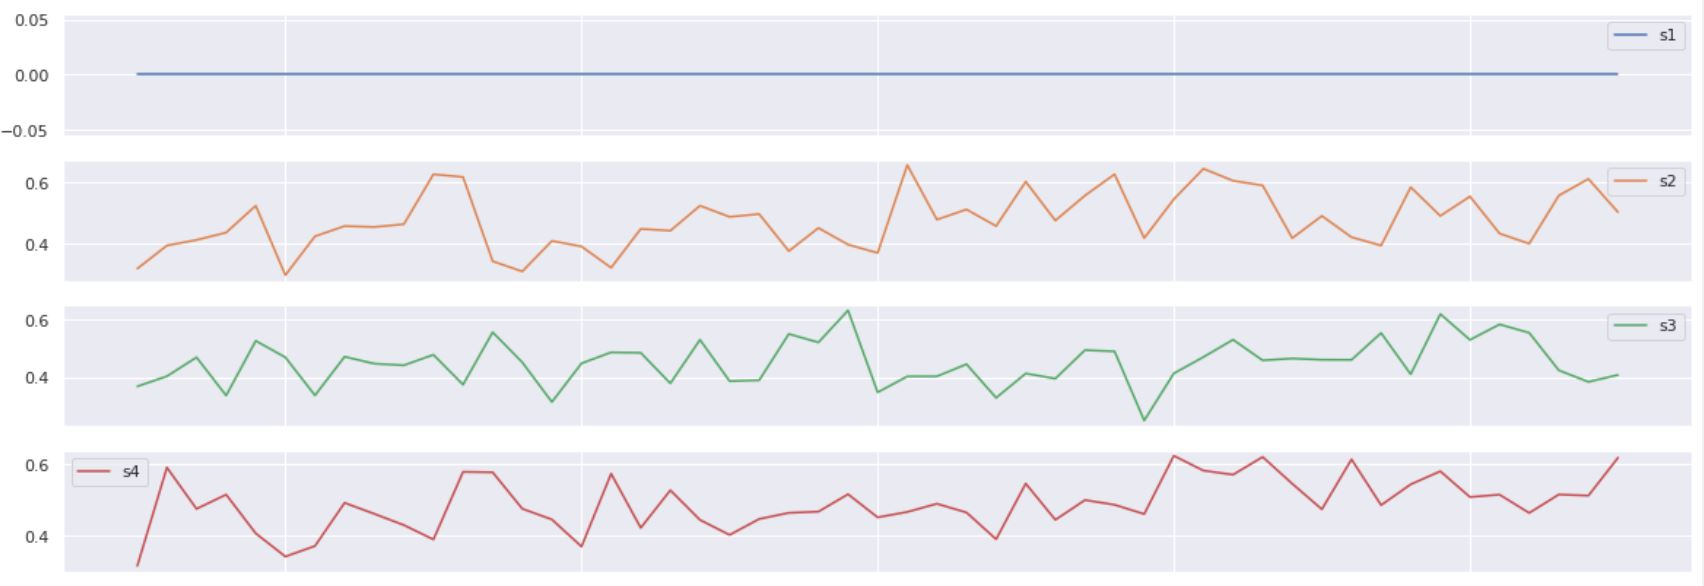

In [148]:
# [WriteCode]
engine_3_df = get_data_non_trivial(train_df, 3)
engine_3_df

setting1  setting2        s2        s3        s4        s7        s8  \
cycle                                                                         
1      0.604651  0.384615  0.316159  0.414758  0.382059  0.242337  0.635294   
2      0.517442  0.307692  0.271663  0.436485  0.264119  0.197318  0.647059   
3      0.488372  0.538462  0.295082  0.354864  0.278159  0.268678  0.682353   
4      0.302326  0.384615  0.355972  0.362106  0.304056  0.257663  0.676471   
5      0.534884  0.692308  0.442623  0.491094  0.312949  0.256705  0.658824   
...         ...       ...       ...       ...       ...       ...       ...   
218    0.366279  0.769231  0.747073  0.739675  0.847426  0.114464  0.794118   
219    0.453488  0.461538  0.627635  0.663731  0.845242  0.086686  0.770588   
220    0.523256  0.461538  0.662763  0.816402  0.816537  0.111111  0.805882   
221    0.558140  0.846154  0.733021  0.672930  0.864743  0.064176  0.782353   
222    0.412791  0.307692  0.793911  0.664514  0.735569  0.066571  0.764706   

             s9       s11       s12       s13       s14       s15       s17  \
cycle                                                                         
1      0.130009  0.342857  0.211411  0.636905  0.191020  0.615162  0.272727   
2      0.182095  0.348571  0.239939  0.648810  0.210772  0.490343  0.272727   
3      0.179461  0.434286  0.223128  0.672619  0.207314  0.632303  0.272727   
4      0.192587  0.331429  0.216505  0.636905  0.204432  0.453163  0.363636   
5      0.172436  0.268571  0.238920  0.648810  0.170849  0.583052  0.363636   
...         ...       ...       ...       ...       ...       ...       ...   
218    0.329805  0.811429  0.101375  0.803571  0.304762  0.881941  0.727273   
219    0.313445  0.782857  0.099847  0.791667  0.322104  0.812651  0.818182   
220    0.354670  0.880000  0.088130  0.767857  0.331063  0.948576  0.636364   
221    0.326709  0.800000  0.113092  0.750000  0.303715  0.810719  0.727273   
222    0.323890  0.720000  0.125828  0.738095  0.333106  0.834621  0.727273   

            s20       s21  cycle_norm  
cycle                                  
1      0.440476  0.572409    0.000000  
2      0.494048  0.393172    0.001908  
3      0.505952  0.493645    0.003817  
4      0.523810  0.481306    0.005725  
5      0.541667  0.583820    0.007634  
...         ...       ...         ...  
218    0.113095  0.185175    0.414122  
219    0.083333  0.217089    0.416031  
220    0.095238  0.196864    0.417939  
221    0.142857  0.227572    0.419847  
222    0.119048  0.223397    0.421756  

[222 rows x 17 columns]

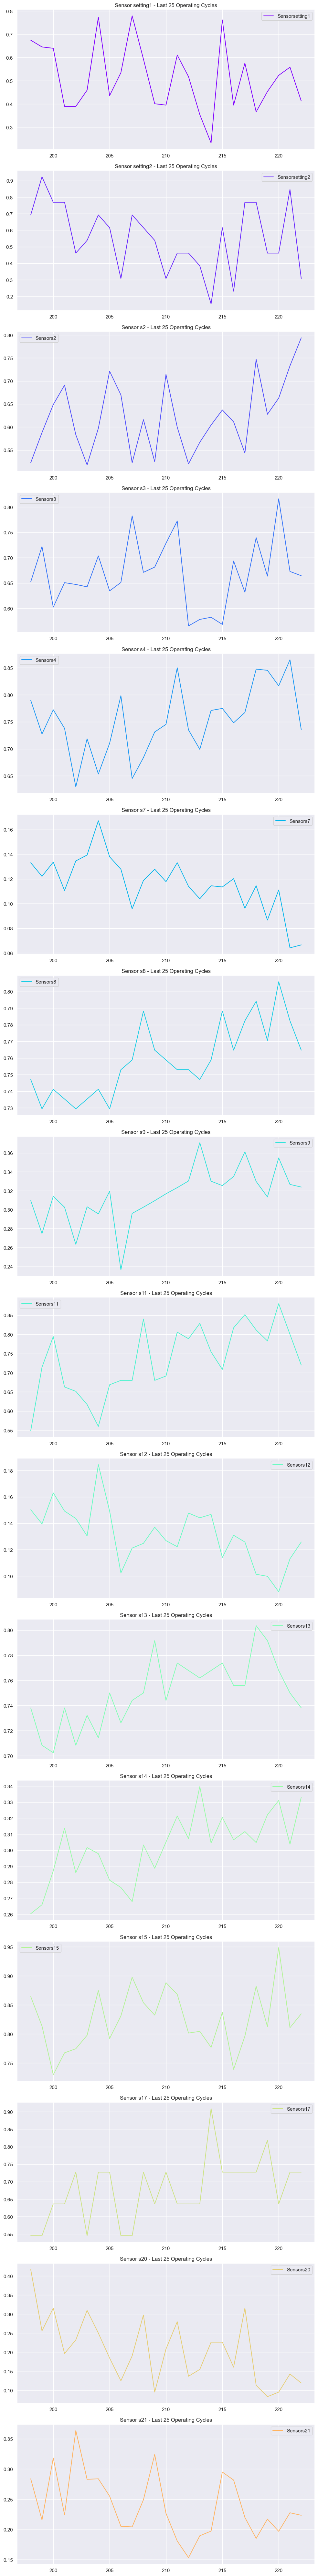

In [149]:
fig, axes = plt.subplots(len(engine_3_df.columns) - 1, 1, figsize=(10, (len(engine_3_df.columns) - 1) * 5))

last_cycles_df = engine_3_df.tail(sequence_length)
colors = plt.cm.rainbow(np.linspace(0, 1, 21))
# last_cycles_df['cycle']
for i, sensor in enumerate(last_cycles_df.columns):
    if (sensor == 'cycle_norm'): continue
    axes[i].plot(last_cycles_df.index, last_cycles_df[sensor], label=f'Sensor{sensor}', color=colors[i])
    axes[i].set_title(f'Sensor {sensor} - Last {sequence_length} Operating Cycles')
    axes[i].legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

### Data Sequence Generation

Any deep learning model requires two data arrays for model training. The first array is the input sequence array X (named "**seq_array**" in this skeleton file) which contains the input features. The second array is the desired target array Y (named "**label_array**" in this skeleton file) which contains the actual output or ground truth. This target output "label_array" is different for binary classification and RUL regression.

In addition, Keras layers expect the input "seq_array" in the shape of a numpy array of 3 dimensions (no. of samples, time steps, features) where no. of samples is the number of training sequences, time steps is the look back window of sequence length and features is the number of features of each sequence at each time step. 

In this section, train_df is used to generate seq_array. Label_array generation is done separately for each prediction task.

In [150]:
# function to reshape features into seq_array: (samples, time steps, features)
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means
    we need to drop those which are below the window-length. """
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements - seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]


# pick the feature columns
sensor_cols = ['s' + str(i) for i in range(1, 22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

# generator for the training sequences
seq_gen = (list(gen_sequence(train_df[train_df['id'] == id], sequence_length, sequence_cols))
           for id in train_df['id'].unique())

# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
# final seq_array which is X input to CNN/LSTM
print(seq_array.shape)

(22220, 25, 25)


## Failure Classification

### Label array generation


In [151]:
# function to generate label_array
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]


train_df

id  cycle  setting1  setting2  setting3   s1        s2        s3  \
0        1      1  0.470930  0.769231       0.0  0.0  0.355972  0.370523   
1        1      2  0.546512  0.230769       0.0  0.0  0.388759  0.399100   
2        1      3  0.418605  0.307692       0.0  0.0  0.313817  0.353298   
3        1      4  0.383721  0.538462       0.0  0.0  0.487119  0.417107   
4        1      5  0.593023  0.461538       0.0  0.0  0.196721  0.476218   
...    ...    ...       ...       ...       ...  ...       ...       ...   
24715  100    148  0.406977  0.230769       0.0  0.0  0.688525  0.620669   
24716  100    149  0.697674  0.230769       0.0  0.0  0.573770  0.627912   
24717  100    150  0.406977  0.769231       0.0  0.0  0.702576  0.787434   
24718  100    151  0.366279  0.769231       0.0  0.0  0.725995  0.651008   
24719  100    152  0.500000  0.692308       0.0  0.0  0.655738  0.679977   

             s4   s5  ...       s15  s16       s17  s18  s19       s20  \
0      0.308580  0.0  ...  0.647755  0.0  0.272727  0.0  0.0  0.559524   
1      0.309360  0.0  ...  0.685659  0.0  0.363636  0.0  0.0  0.488095   
2      0.445398  0.0  ...  0.564462  0.0  0.272727  0.0  0.0  0.404762   
3      0.237285  0.0  ...  0.558909  0.0  0.363636  0.0  0.0  0.470238   
4      0.321217  0.0  ...  0.556736  0.0  0.363636  0.0  0.0  0.577381   
...         ...  ...  ...       ...  ...       ...  ...  ...       ...   
24715  0.734009  0.0  ...  0.838484  0.0  0.545455  0.0  0.0  0.160714   
24716  0.812480  0.0  ...  0.871801  0.0  0.636364  0.0  0.0  0.196429   
24717  0.847894  0.0  ...  0.883631  0.0  0.727273  0.0  0.0  0.130952   
24718  0.772387  0.0  ...  0.865524  0.0  0.636364  0.0  0.0  0.083333   
24719  0.920437  0.0  ...  0.866007  0.0  0.727273  0.0  0.0  0.232143   

            s21  RUL  label1  cycle_norm  
0      0.446331  258       0    0.000000  
1      0.534836  257       0    0.001908  
2      0.458577  256       0    0.003817  
3      0.391966  255       0    0.005725  
4      0.543371  254       0    0.007634  
...         ...  ...     ...         ...  
24715  0.083960    4       1    0.280534  
24716  0.094628    3       1    0.282443  
24717  0.181464    2       1    0.284351  
24718  0.188051    1       1    0.286260  
24719  0.196772    0       1    0.288168  

[24720 rows x 29 columns]

In [152]:
# generate labels (generated from "label1" col as its binary classification)
label_gen = [gen_labels(train_df[train_df['id'] == id], sequence_length, ['label1'])
             for id in train_df['id'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)

# final label_array which is Y target output for CNN and LSTM
print(label_array.shape)

(22220, 1)


### CNN Model
In this section, build a 1D CNN network to do binary classification. The choice of network architecture - no. of layers, type of layers (1D CNN, maxpooling etc.), nodes per layer, activations - is left to students. Please include the following:
- name the model as "model_cnn_bin"
- dropout layer after each CNN layer (drop probability of your choice)
- output dense layer with appropriate no. of nodes and activation for binary classification
- appropriate loss function and optimizer.

Set 'accuracy' as the metric.

Print the model summary.


In [153]:
# [WriteCode]
# Build the 1D CNN model for binary classification
def build_model_cnn_bin(input_shape):
    model_cnn_bin = Sequential()

    # First Convolutional Layer
    model_cnn_bin.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
    model_cnn_bin.add(Dropout(0.3))  # Dropout with 30% probability

    # MaxPooling Layer
    # model_cnn_bin.add(MaxPooling1D(pool_size=2))

    # Second Convolutional Layer
    model_cnn_bin.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model_cnn_bin.add(Dropout(0.3))  # Dropout with 30% probability

    # MaxPooling Layer
    # model_cnn_bin.add(MaxPooling1D(pool_size=2))

    # Third Convolutional Layer (Optional, can be adjusted based on complexity)
    model_cnn_bin.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model_cnn_bin.add(Dropout(0.3))  # Dropout with 30% probability

    # MaxPooling Layer
    model_cnn_bin.add(MaxPooling1D(pool_size=2))

    # Flatten the output of the last pooling layer
    model_cnn_bin.add(Flatten())

    # Dense Layer for Binary Classification
    # model_cnn_bin.add(Dense(64, activation='relu'))
    # model_cnn_bin.add(Dropout(0.5))  # Dropout with 50% probability to prevent overfitting

    # Output Layer for Binary Classification (1 neuron with sigmoid activation)
    model_cnn_bin.add(Dense(1, activation='sigmoid'))

    # Compile the model with binary cross-entropy loss and Adam optimizer
    model_cnn_bin.compile(optimizer=Adam(learning_rate=0.001),
                          loss='binary_crossentropy',
                          metrics=['accuracy'])

    return model_cnn_bin


#### Model Training

Fit the model using **seq_array** and **label_array** with epochs and batch_size set according to the parameter values in the form on top. Use validation_split = 0.05

##### Use callback: "**keras.callbacks.TensorBoard(log_dir=get_run_logdir("run_cnn_bin") , histogram_freq=1, write_graph= True, update_freq='epoch')**" to store the model training to Tensorboard log file "run_cnn_bin" for visualization.

In [154]:
%%time
cb = keras.callbacks.TensorBoard(log_dir=get_run_logdir("run_cnn_bin"), histogram_freq=1, write_graph=True,
                                 update_freq='epoch')

# [WriteCode]
# Train and evaluate the CNN model
# Assuming X is your feature data and y is your binary labels
# X_train, X_test, y_train, y_test = train_test_split(seq_array, label_array, test_size=0.2, random_state=40)
X_train =  seq_array
y_train = label_array
r = pd.DataFrame(y_train, columns=['label'])
num1 = 0
num2 = 0
for i in r['label']:
    if i == 1:
        num1 += 1
    else:
        num2 += 1
print(num1)
print(num2)
print(X_train)
print(y_train)

3100
19120
[[[0.47093022 0.7692308  0.         ... 0.         0.5595238  0.44633082]
  [0.54651165 0.23076923 0.         ... 0.         0.48809522 0.53483623]
  [0.41860464 0.30769232 0.         ... 0.         0.4047619  0.45857686]
  ...
  [0.16860466 0.3846154  0.         ... 0.         0.5297619  0.53344464]
  [0.8313953  0.61538464 0.         ... 0.         0.53571427 0.54940164]
  [0.44767442 0.15384616 0.         ... 0.         0.4047619  0.4746266 ]]

 [[0.54651165 0.23076923 0.         ... 0.         0.48809522 0.53483623]
  [0.41860464 0.30769232 0.         ... 0.         0.4047619  0.45857686]
  [0.38372093 0.53846157 0.         ... 0.         0.4702381  0.39196587]
  ...
  [0.8313953  0.61538464 0.         ... 0.         0.53571427 0.54940164]
  [0.44767442 0.15384616 0.         ... 0.         0.4047619  0.4746266 ]
  [0.5523256  0.3846154  0.         ... 0.         0.45238096 0.45969012]]

 [[0.41860464 0.30769232 0.         ... 0.         0.4047619  0.45857686]
  [0.383720

In [155]:
cnn_model = build_model_cnn_bin((X_train.shape[1], X_train.shape[2]))
print(X_train.shape[1])
print(X_train.shape[2])
cnn_model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

history = cnn_model.fit(X_train, y_train, epochs=ep, batch_size=ba, validation_split=0.05, callbacks=[cb])

25
25
Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_60 (Conv1D)           (None, 23, 32)            2432      
_________________________________________________________________
dropout_85 (Dropout)         (None, 23, 32)            0         
_________________________________________________________________
conv1d_61 (Conv1D)           (None, 21, 64)            6208      
_________________________________________________________________
dropout_86 (Dropout)         (None, 21, 64)            0         
_________________________________________________________________
conv1d_62 (Conv1D)           (None, 19, 128)           24704     
_________________________________________________________________
dropout_87 (Dropout)         (None, 19, 128)           0         
_________________________________________________________________
max_pooling1d_29 (MaxPooling (None, 9, 128)    

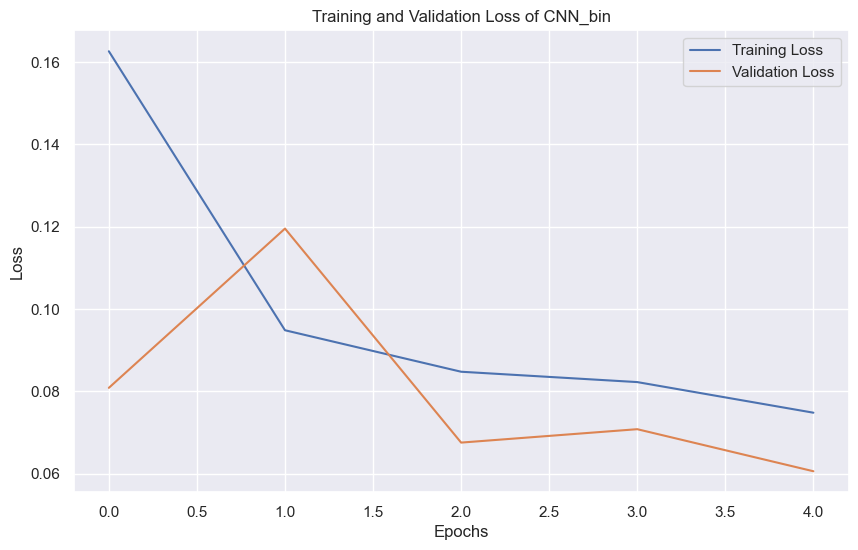

In [156]:
# Plot the loss curves of the training set and the validation set
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss of CNN_bin')
plt.legend()
plt.show()

#### Training data performance metrics

- Determine the accuracy of prediction of the trained model on the training data
- Print the confusion matrix for training data prediction
- Print the precision and recall for training data prediction

In [157]:
# [WriteCode]
# Compute the accuracy, confusion matrix, precision, recall, and F1 score for training data
# Predict on training data
y_pred_cnn = cnn_model.predict(X_train)
print(y_pred_cnn)
y_pred_cnn = (y_pred_cnn > 0.5).astype(int)  # Convert probabilities to binary labels


[[4.9084538e-05]
 [5.3510572e-05]
 [6.8967522e-05]
 ...
 [9.9390930e-01]
 [9.9459690e-01]
 [9.9546206e-01]]


In [158]:
# Compute metrics
accuracy = accuracy_score(y_train, y_pred_cnn)
conf_matrix = confusion_matrix(y_train, y_pred_cnn)
precision = precision_score(y_train, y_pred_cnn)
recall = recall_score(y_train, y_pred_cnn)
f1 = f1_score(y_train, y_pred_cnn)

print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix: \n{conf_matrix}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Accuracy: 0.9745724572457246
Confusion Matrix: 
[[18871   249]
 [  316  2784]]
Precision: 0.9179030662710188
Recall: 0.8980645161290323
F1 Score: 0.907875428012392


#### Test data for prediction

To evaluate the performance on the test data, only the last cycles of data for each engine id in the test data is kept for testing purposes. In order to compare the results to the target, we pick the last sequence for each engine id in the test data (excluding engine ids whose last cycle is shorter than "sequence length" size).

In [159]:
seq_array_test_last = [test_df[test_df['id'] == id][sequence_cols].values[-sequence_length:]
                       for id in test_df['id'].unique() if len(test_df[test_df['id'] == id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)

# Last cycle test data - seq_array for test data
print(seq_array_test_last.shape)

y_mask = [len(test_df[test_df['id'] == id]) >= sequence_length for id in test_df['id'].unique()]
label_array_test_last = test_df.groupby('id')['label1'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0], 1).astype(np.float32)

# Last cycle test data - label_array for test data
print(label_array_test_last.shape)

(100, 25, 25)
(100, 1)


#### Test data performance metrics

- Determine the accuracy of prediction of the trained model on the test data
- Print the confusion matrix for test data prediction
- Print the precision, recall and F1 score for test data prediction

*Note*: use seq_array_test_last and label_array_test_last generated in the cell above as X and Y arrays (in place of seq_array and label_array) for performing prediction and calculating metrics

Accuracy on test data: 0.97
Confusion Matrix:
[[79  1]
 [ 2 18]]
Precision: 0.9473684210526315
Recall: 0.9
F1 Score: 0.9230769230769231


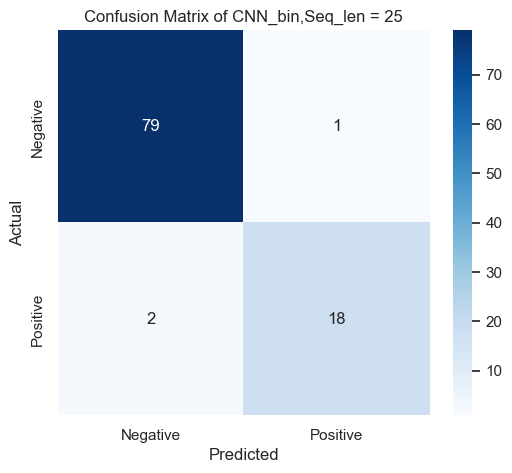

In [160]:
# [WriteCode]
X_test = seq_array_test_last
y_test = label_array_test_last
# Make predictions
y_pred = cnn_model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate accuracy
accuracy_cnn = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy on test data: {accuracy_cnn}")

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_binary)
print(f"Confusion Matrix:\n{conf_matrix}")

# Compute precision, recall, and F1 score
precision_cnn = precision_score(y_test, y_pred_binary, zero_division=0)
recall_cnn = recall_score(y_test, y_pred_binary, zero_division=0)
f1_cnn = f1_score(y_test, y_pred_binary, zero_division=0)

print(f"Precision: {precision_cnn}")
print(f"Recall: {recall_cnn}")
print(f"F1 Score: {f1_cnn}")
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of CNN_bin,Seq_len = 25')
plt.show()

#### Hyperparameter Optimisation

This involves finding the best network architecture (no. and types of layers, no. of nodes per layer, activations) and values for the learning rate, optimizer, dropout rate etc., even batch size and no. of epochs, parameters of the CNN model for binary classification. 

Since a systematic search is highly computationally expensive, you will only design and implement an improved CNN model with the **same** network architecture (no. and types of layers, no. of nodes per layer, activations) as the baseline CNN model, but you are free to set different values for the other parameters (you may vary the value(s) of one or more parameters).

In the cell below, enter the improved CNN model (named "model_cnn_bin_alt").
- Fit the model. Use validation_split = 0.05
- Use callback: "**keras.callbacks.TensorBoard(log_dir=get_run_logdir("run_cnn_bin_alt") , histogram_freq=1, write_graph= True, update_freq='epoch')**" to store the model training to Tensorboard log file "run_cnn_bin_alt" for visualization.
- Evaluate and print training data accuracy, confusion matrix, precision and recall.
- Evaluate and print test data accuracy, confusion matrix, precision, recall and F1 score (use seq_array_test_last and label_array_test_last generated previously).

In [161]:
%%time
cb = keras.callbacks.TensorBoard(log_dir=get_run_logdir("run_cnn_bin_alt"), histogram_freq=1, write_graph=True,
                                 update_freq='epoch')

# [WriteCode]
def build_model_cnn_bin_alt(input_shape):
    model_cnn_bin_alt = Sequential()

    # First Convolutional Layer
    model_cnn_bin_alt.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    model_cnn_bin_alt.add(Dropout(0.4))  # Increased dropout rate

    # MaxPooling Layer
    model_cnn_bin_alt.add(MaxPooling1D(pool_size=2))

    # Second Convolutional Layer
    model_cnn_bin_alt.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model_cnn_bin_alt.add(Dropout(0.4))  # Increased dropout rate

    # MaxPooling Layer
    model_cnn_bin_alt.add(MaxPooling1D(pool_size=2))

    # Third Convolutional Layer (Optional)
    model_cnn_bin_alt.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
    model_cnn_bin_alt.add(Dropout(0.4))  # Increased dropout rate

    # MaxPooling Layer
    model_cnn_bin_alt.add(MaxPooling1D(pool_size=2))

    # Flatten the output of the last pooling layer
    model_cnn_bin_alt.add(Flatten())

    # Dense Layer for Binary Classification
    model_cnn_bin_alt.add(Dense(128, activation='relu'))
    model_cnn_bin_alt.add(Dropout(0.5))  # Increased dropout rate

    # Output Layer for Binary Classification (1 neuron with sigmoid activation)
    model_cnn_bin_alt.add(Dense(1, activation='sigmoid'))

    # Compile the model with binary cross-entropy loss and Adam optimizer
    model_cnn_bin_alt.compile(optimizer=Adam(learning_rate=0.0005),  # Decreased learning rate
                              loss='binary_crossentropy',
                              metrics=['accuracy'])

    return model_cnn_bin_alt


from tensorflow.keras.callbacks import TensorBoard

# Build the model
model_cnn_bin_alt = build_model_cnn_bin_alt((X_train.shape[1], X_train.shape[2]))

# Set up TensorBoard callback
tensorboard_callback = TensorBoard(log_dir=get_run_logdir("run_cnn_bin_alt"),
                                   histogram_freq=1,
                                   write_graph=True,
                                   update_freq='epoch')

# Fit the model
history = model_cnn_bin_alt.fit(X_train, y_train, epochs=5,  # Adjust epochs as needed
                                validation_split=0.05,
                                callbacks=[cb])

Epoch 1/5
660/660 [==============================] - 11s 13ms/step - loss: 0.1495 - accuracy: 0.9405 - val_loss: 0.1482 - val_accuracy: 0.9613
Epoch 2/5
660/660 [==============================] - 8s 12ms/step - loss: 0.1059 - accuracy: 0.9569 - val_loss: 0.1314 - val_accuracy: 0.9874
Epoch 3/5
660/660 [==============================] - 8s 12ms/step - loss: 0.0952 - accuracy: 0.9615 - val_loss: 0.1386 - val_accuracy: 0.9712
Epoch 4/5
660/660 [==============================] - 8s 12ms/step - loss: 0.0910 - accuracy: 0.9607 - val_loss: 0.1500 - val_accuracy: 0.9811
Epoch 5/5
660/660 [==============================] - 8s 12ms/step - loss: 0.0854 - accuracy: 0.9640 - val_loss: 0.0968 - val_accuracy: 0.9784
CPU times: total: 2min 19s
Wall time: 43.9 s


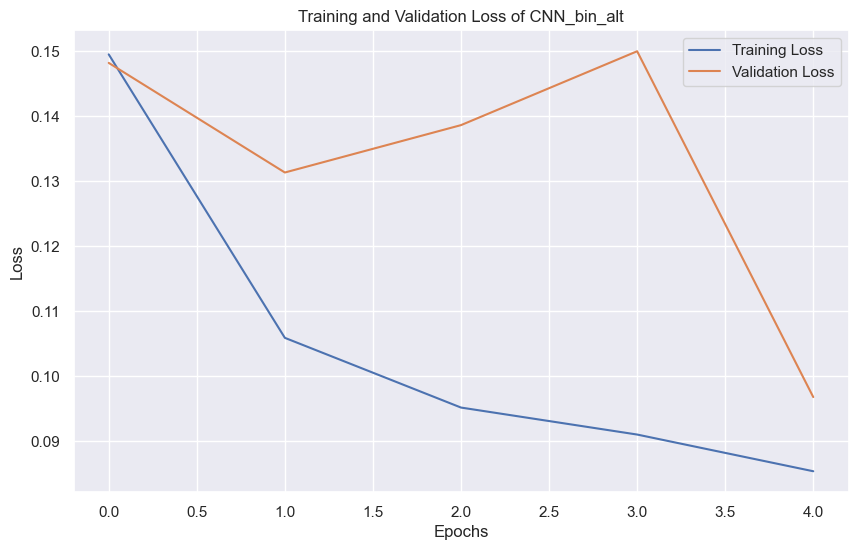

In [162]:
# Plot the loss curves of the training set and the validation set

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss of CNN_bin_alt')
plt.legend()
plt.show()

Training Accuracy: 0.9691719171917191
Training Confusion Matrix:
[[18812   308]
 [  377  2723]]
Training Precision: 0.8983833718244804
Training Recall: 0.8783870967741936
Test Accuracy: 0.95
Test Confusion Matrix:
[[79  1]
 [ 4 16]]
Test Precision: 0.9411764705882353
Test Recall: 0.8
Test F1 Score: 0.8648648648648648


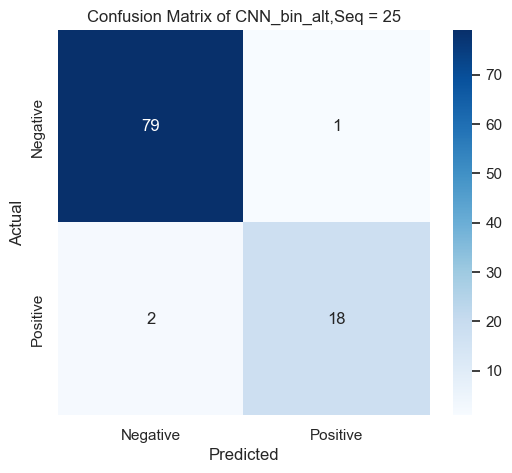

In [163]:

# Evaluate on training data
y_train_pred = model_cnn_bin_alt.predict(X_train)
y_train_pred_binary = (y_train_pred > 0.5).astype(int)

train_accuracy = accuracy_score(y_train, y_train_pred_binary)
train_conf_matrix = confusion_matrix(y_train, y_train_pred_binary)
train_precision = precision_score(y_train, y_train_pred_binary, zero_division=0)
train_recall = recall_score(y_train, y_train_pred_binary, zero_division=0)

print(f"Training Accuracy: {train_accuracy}")
print(f"Training Confusion Matrix:\n{train_conf_matrix}")
print(f"Training Precision: {train_precision}")
print(f"Training Recall: {train_recall}")

# Evaluate on test data
y_test_pred = model_cnn_bin_alt.predict(X_test)
y_test_pred_binary = (y_test_pred > 0.5).astype(int)

test_accuracy_cnn_alt = accuracy_score(y_test, y_test_pred_binary)
test_conf_matrix = confusion_matrix(y_test, y_test_pred_binary)
test_precision_cnn_alt = precision_score(y_test, y_test_pred_binary, zero_division=0)
test_recall_cnn_alt = recall_score(y_test, y_test_pred_binary, zero_division=0)
test_f1_cnn_alt = f1_score(y_test, y_test_pred_binary, zero_division=0)

print(f"Test Accuracy: {test_accuracy_cnn_alt}")
print(f"Test Confusion Matrix:\n{test_conf_matrix}")
print(f"Test Precision: {test_precision_cnn_alt}")
print(f"Test Recall: {test_recall_cnn_alt}")
print(f"Test F1 Score: {test_f1_cnn_alt}")
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of CNN_bin_alt,Seq = 25')
plt.show()

### LSTM Network
In this section build a LSTM network to do binary classification. The choice of network architecture - no. of layers, type of layers, nodes per layer, activations - is left to students. Please include the following:
- name the model as "model_lstm_bin"
- dropout layer after each LSTM layer (drop probability of your choice)
- output dense layer with appropriate no. of nodes and activation for binary classification
- appropriate loss function and optimizer.

Set 'accuracy' as the metric.

Print the model summary.



In [170]:
# Build the LSTM model
def build_model_lstm_bin(input_shape, dropout_rate=0.1):
    model_lstm_bin = Sequential()

    # First LSTM layer 
    model_lstm_bin.add(LSTM(64, activation='tanh', return_sequences=True, input_shape=input_shape))
    model_lstm_bin.add(Dropout(dropout_rate))

    # Second LSTM layer 
    model_lstm_bin.add(LSTM(64, activation='tanh', return_sequences=True))
    model_lstm_bin.add(Dropout(dropout_rate))

    # Third LSTM layer 
    model_lstm_bin.add(LSTM(64, activation='tanh'))
    model_lstm_bin.add(Dropout(dropout_rate))

    # Fully connected Dense layer for binary classification
    model_lstm_bin.add(Dense(1, activation='sigmoid'))

    # Compile the model with binary cross-entropy loss and Adam optimizer
    model_lstm_bin.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                           loss='binary_crossentropy',
                           metrics=['accuracy'])
    return model_lstm_bin

input_shape = (X_train.shape[1], X_train.shape[2])
model_lstm_bin = build_model_lstm_bin(input_shape)

model_lstm_bin.summary()




Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 25, 64)            23040     
_________________________________________________________________
dropout_98 (Dropout)         (None, 25, 64)            0         
_________________________________________________________________
lstm_25 (LSTM)               (None, 25, 64)            33024     
_________________________________________________________________
dropout_99 (Dropout)         (None, 25, 64)            0         
_________________________________________________________________
lstm_26 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dropout_100 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_38 (Dense)             (None, 1)               

#### Model Training

Fit the model on **seq_array** and **label_array** with epochs and batch_size set according to the parameter values in the form on top. Use validation_split = 0.05

##### Use callback: "**keras.callbacks.TensorBoard(log_dir=get_run_logdir("run_lstm_bin") , histogram_freq=1, write_graph= True, update_freq='epoch')**" to store the model training to Tensorboard log file "run_lstm_bin" for visualization.

In [ ]:
cb = keras.callbacks.TensorBoard(log_dir=get_run_logdir("run_lstm_bin"), histogram_freq=1, write_graph=True,
                                 update_freq='epoch')

history = model_lstm_bin.fit(
    X_train,
    y_train,
    epochs=ep,
    batch_size=16,
    validation_split=0.05,
    callbacks=[cb, early_stopping]
)

# Plot the Training and Validation Loss of LSTM_bin
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss of LSTM_bin')
plt.legend()
plt.show()


Epoch 1/5
1320/1320 [==============================] - 99s 66ms/step - loss: 0.1586 - accuracy: 0.9380 - val_loss: 0.1140 - val_accuracy: 0.9640
Epoch 2/5
 320/1320 [======>.......................] - ETA: 1:06 - loss: 0.1129 - accuracy: 0.9555

#### Training data performance metrics

- Determine the accuracy of prediction of the trained model on the training data
- Print the confusion matrix for training data prediction
- Print the precision and recall for training data prediction

In [ ]:
y_train_pred = model_lstm_bin.predict(X_train)
y_train_pred_binary = (y_train_pred > 0.5).astype(int)  

# Accuracy
train_accuracy = accuracy_score(y_train, y_train_pred_binary)

# Conf_Matrix
train_conf_matrix = confusion_matrix(y_train, y_train_pred_binary)

# Precision and Recall
train_precision = precision_score(y_train, y_train_pred_binary, zero_division=0)
train_recall = recall_score(y_train, y_train_pred_binary, zero_division=0)


print(f"Training Accuracy: {train_accuracy}")
print(f"Training Confusion Matrix:\n{train_conf_matrix}")
print(f"Training Precision: {train_precision}")
print(f"Training Recall: {train_recall}")

#### Test data for prediction

To evaluate the performance on the test data, only the last cycles of data for each engine id in the test data is kept for testing purposes. In order to compare the results to the target, we pick the last sequence for each engine id in the test data (excluding engine ids whose last cycle is shorter than "sequence length" size).

In [ ]:
seq_array_test_last = [test_df[test_df['id'] == id][sequence_cols].values[-sequence_length:]
                       for id in test_df['id'].unique() if len(test_df[test_df['id'] == id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)

# Last cycle test data - seq_array for test data
print(seq_array_test_last.shape)

y_mask = [len(test_df[test_df['id'] == id]) >= sequence_length for id in test_df['id'].unique()]
label_array_test_last = test_df.groupby('id')['label1'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0], 1).astype(np.float32)

# Last cycle test data - label_array for test data
print(label_array_test_last.shape)

In [ ]:
seq_array_test_last = [test_df[test_df['id'] == id][sequence_cols].values[-sequence_length:]
                       for id in test_df['id'].unique() if len(test_df[test_df['id'] == id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)

# Last cycle test data - seq_array for test data
print(seq_array_test_last.shape)

y_mask = [len(test_df[test_df['id'] == id]) >= sequence_length for id in test_df['id'].unique()]
label_array_test_last = test_df.groupby('id')['label1'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0], 1).astype(np.float32)

# Last cycle test data - label_array for test data
print(label_array_test_last.shape)

X_test = seq_array_test_last
y_test = label_array_test_last

# Using test data to predict
y_pred = model_lstm_bin.predict(X_test)

# Convert probability into binary classification results
y_pred_binary = (y_pred > 0.5).astype(int)

# Accurcay
accuracy_lstm = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy on test data: {accuracy_lstm}")

# Conf_Matrix
conf_matrix = confusion_matrix(y_test, y_pred_binary)
print(f"Confusion Matrix:\n{conf_matrix}")

# Precision, Recall, F1 score
precision_lstm = precision_score(y_test, y_pred_binary, zero_division=0)
recall_lstm = recall_score(y_test, y_pred_binary, zero_division=0)
f1_lstm = f1_score(y_test, y_pred_binary, zero_division=0)

print(f"Precision: {precision_lstm}")
print(f"Recall: {recall_lstm}")
print(f"F1 Score: {f1_lstm}")
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#### Hyperparameter Optimisation

This involves finding the best network architecture (no. and types of layers, no. of nodes per layer, activations) and values for the learning rate, optimizer, dropout rate etc., even batch size and no. of epochs, parameters of the LSTM model for binary classification. 

Since a systematic search is highly computationally expensive, you will only design and implement an improved LSTM model with the **same** network architecture (no. and types of layers, no. of nodes per layer, activations) as the baseline LSTM model, but you are free to set different values for the other parameters (you may vary the value(s) of one or more parameters).

In the cell below, enter the improved LSTM model (named "model_lstm_bin_alt").

- Fit the model. Use validation_split = 0.05
- Use callback: "**keras.callbacks.TensorBoard(log_dir=get_run_logdir("run_lstm_bin_alt") , histogram_freq=1, write_graph= True, update_freq='epoch')**" to store the model training to Tensorboard log file "run_lstm_bin_alt" for visualization.
- Evaluate and print training data accuracy, confusion matrix, precision and recall.
- Evaluate and print test data accuracy, confusion matrix, precision, recall and F1 score (use seq_array_test_last and label_array_test_last generated previously).

In [ ]:
cb = keras.callbacks.TensorBoard(log_dir=get_run_logdir("run_lstm_bin_alt"), histogram_freq=1, write_graph=True,
                                 update_freq='epoch')

model_lstm_bin_alt = Sequential([
    LSTM(64, activation='tanh', return_sequences=True, input_shape=input_shape),
    Dropout(0.5),

    LSTM(64, activation='tanh', return_sequences=True),
    Dropout(0.5),
    
    LSTM(64, activation='tanh'),
    Dropout(0.5),
    Dense(1, activation='sigmoid'),

])


optimizer = Adam(learning_rate=0.0005)  
model_lstm_bin_alt.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])


model_lstm_bin_alt.summary()

history = model_lstm_bin_alt.fit(
    X_train, y_train,
    epochs=10,  
    batch_size=64, 
    validation_split=0.05,
    callbacks=[cb],
    verbose=1
)

# Performance evaluation on training data
y_train_pred = model_lstm_bin_alt.predict(seq_array)
y_train_pred_binary = (y_train_pred > 0.5).astype(int)

train_accuracy = accuracy_score(label_array, y_train_pred_binary)
train_conf_matrix = confusion_matrix(label_array, y_train_pred_binary)
train_precision = precision_score(label_array, y_train_pred_binary, zero_division=0)
train_recall = recall_score(label_array, y_train_pred_binary, zero_division=0)

print("\nTraining Data Metrics:")
print(f"Accuracy: {train_accuracy}")
print(f"Confusion Matrix:\n{train_conf_matrix}")
print(f"Precision: {train_precision}")
print(f"Recall: {train_recall}")

# Performance evaluation on test data
y_test_pred = model_lstm_bin_alt.predict(seq_array_test_last)
y_test_pred_binary = (y_test_pred > 0.5).astype(int)

test_accuracy_lstm_alt = accuracy_score(label_array_test_last, y_test_pred_binary)
test_conf_matrix = confusion_matrix(label_array_test_last, y_test_pred_binary)
test_precision_lstm_alt = precision_score(label_array_test_last, y_test_pred_binary, zero_division=0)
test_recall_lstm_alt = recall_score(label_array_test_last, y_test_pred_binary, zero_division=0)
test_f1_lstm_alt = f1_score(label_array_test_last, y_test_pred_binary, zero_division=0)

print("\nTest Data Metrics:")
print(f"Accuracy: {test_accuracy_lstm_alt}")
print(f"Confusion Matrix:\n{test_conf_matrix}")
print(f"Precision: {test_precision_lstm_alt}")
print(f"Recall: {test_recall_lstm_alt}")
print(f"F1 Score: {test_f1_lstm_alt}")

#Plot the Conf_Matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Plot the Training and Validation Loss of LSTM_bin_alt
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss of LSTM_bin_alt')
plt.legend()
plt.show()

### Comparing CNN 1D and LSTM models for binary classification

Using a Pandas dataframe, combine the results obtained for binary classification such as accuracy, precision, recall and F1 score for test data of the CNN, LSTM, alt-CNN and alt-LSTM models for binary classification.

Display this dataframe.

In [ ]:
# Create DataFrame
model_comparison_df = pd.DataFrame({
    'MODEL': ['CNN', 'LSTM', 'alt-CNN', 'alt-LSTM'],
    'ACCURACY': [accuracy_cnn, accuracy_lstm, test_accuracy_cnn_alt, test_accuracy_lstm_alt],
    'PRECISION': [precision_cnn, precision_lstm, test_precision_cnn_alt, test_precision_lstm_alt],
    'RECALL': [recall_cnn, recall_lstm, test_recall_cnn_alt, test_recall_lstm_alt],
    'F1 SCORE': [f1_cnn, f1_lstm, test_f1_cnn_alt, test_f1_lstm_alt]
})

# Show DataFrame
print(model_comparison_df)

## RUL Regression

### Label array generation


In [ ]:
# function to generate labels
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]


# generate labels (generated from "RUL" col as it's RUL regression)
label_gen = [gen_labels(train_df[train_df['id'] == id], sequence_length, ['RUL'])
             for id in train_df['id'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)

# final label_array which is Y target output to CNN/LSTM
print(label_array.shape)

### CNN Model

In this section, build a 1D CNN network to do RUL regression. Use the **same** CNN network architecture (no. and types of layers, no. of nodes per layer, activations) as the binary classification case. Please include the following:
- name the model as "model_cnn_rul"
- use the **same** parameter values as the baseline CNN network for binary classification
- output dense layer with appropriate no. of nodes and activation for RUL regression
- appropriate loss function and optimizer.

Set mean absolute error MAE as the metric.

Print the model summary.

In [ ]:
# [WriteCode]

def build_model_cnn_rul(input_shape):
    model_cnn_rul = Sequential()

    # First Convolutional Layer
    model_cnn_rul.add(Conv1D(filters=32, kernel_size=3, activation='relu',input_shape=input_shape))
    model_cnn_rul.add(Dropout(0.2))  # Dropout with 30% probability

    # MaxPooling Layer
    #model_cnn_rul.add(MaxPooling1D(pool_size=2))

    # Second Convolutional Layer
    model_cnn_rul.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model_cnn_rul.add(Dropout(0.2))  # Dropout with 30% probability

    # MaxPooling Layer
    #model_cnn_rul.add(MaxPooling1D(pool_size=2))

    # Third Convolutional Layer (Optional, can be adjusted based on complexity)
    model_cnn_rul.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model_cnn_rul.add(Dropout(0.2))  # Dropout with 30% probability

    # MaxPooling Layer
    model_cnn_rul.add(MaxPooling1D(pool_size=2))

    # Flatten the output of the last pooling layer
    model_cnn_rul.add(Flatten())

    # Dense Layer for RUL Regression
    #model_cnn_rul.add(Dense(32, activation='relu'))
    #model_cnn_rul.add(Dropout(0.5))  # Dropout with 50% probability to prevent overfitting

    # Output Layer for RUL Regression (1 neuron with linear activation)
    model_cnn_rul.add(Dense(1, activation='linear'))

    # Compile the model with mean absolute error loss and Adam optimizer
    model_cnn_rul.compile(optimizer=Adam(learning_rate=0.001),
                          loss='mse',
                          metrics=['mae'])

    # Print the model summary
    model_cnn_rul.summary()

    return model_cnn_rul

#### Model Training

Fit the model on **seq_array** and **label_array** with epochs and batch_size set according to the parameter values in the form on top. Use validation_split = 0.05

##### Use callback: "**keras.callbacks.TensorBoard(log_dir=get_run_logdir("run_cnn_rul") , histogram_freq=1, write_graph= True, update_freq='epoch')**" to store the model training to Tensorboard log file "run_cnn_rul" for visualization.

In [ ]:
%%time
cb = keras.callbacks.TensorBoard(log_dir=get_run_logdir("run_cnn_rul"), histogram_freq=1, write_graph=True,
                                 update_freq='epoch')

# [WriteCode]
# Train and evaluate the CNN model

# Set up early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Build the model
model_cnn_rul = build_model_cnn_rul(input_shape=(X_train.shape[1], X_train.shape[2]))

# Train the model
epochs = 5
batch_size = 32
history = model_cnn_rul.fit(seq_array, label_array, epochs=epochs, batch_size=batch_size, validation_split=0.05, callbacks=[cb])

# Plot the training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss of CNN_rul,Seq_len=25', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.show()

#### Training data performance metrics

- Print the "mean absolute error" metric for training data prediction.

In [ ]:
# [WriteCode]

# Use the model to make predictions on the training data
y_pred = model_cnn_rul.predict(X_train)

# Convert predictions to a list to match the shape of y_train
y_pred_list = y_pred.flatten().tolist()

# Calculate and print the Mean Absolute Error (MAE) on training data
mae_train = mean_absolute_error(y_train, y_pred_list)
print(f"Mean Absolute Error (MAE) on training data: {mae_train}")

#### Test data for prediction

To evaluate the performance on the test data, only the last cycles of data for each engine id in the test data is kept for testing purposes. In order to compare the results to the target, we pick the last sequence for each engine id in the test data (excluding engine ids whose last cycle is shorter than "sequence length" size).

In [ ]:
seq_array_test_last = [test_df[test_df['id'] == id][sequence_cols].values[-sequence_length:]
                       for id in test_df['id'].unique() if len(test_df[test_df['id'] == id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)

# Last cycle test data - seq_array for test data
print(seq_array_test_last.shape)

y_mask = [len(test_df[test_df['id'] == id]) >= sequence_length for id in test_df['id'].unique()]
label_array_test_last = test_df.groupby('id')['RUL'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0], 1).astype(np.float32)

# Last cycle test data - label_array for test data
print(label_array_test_last.shape)

#### Test data performance metrics
- print the "mean absolute error" metric for test data prediction

*Note*: use seq_array_test_last and label_array_test_last generated in the cell above as X and Y arrays (in place of seq_array and label_array) for performing prediction and calculating metrics

In [ ]:
# [WriteCode]

# Make predictions using the model
predictions = model_cnn_rul.predict(seq_array_test_last)

# Flatten predictions to a 1D array for MAE calculation
predictions = predictions.flatten()

# Calculate MAE
mae = mean_absolute_error(label_array_test_last, predictions)

# Print MAE
print("Mean Absolute Error on test data:", mae)
model_cnn_rul_test_mae = mae
rul = model_cnn_rul.predict(seq_array_test_last)
plt.figure(figsize=(10, 6))
plt.plot(rul, label='rul_predict')
plt.plot(label_array_test_last, label='rul_gt')
plt.title('rul_predict vs rul_gt of CNN_rul,Seq_len=25', fontsize=16)
plt.xlabel('Test Samples', fontsize=14)
plt.ylabel('RUL', fontsize=14)
plt.legend()
plt.show()

#### Hyperparameter Optimisation

This involves finding the best network architecture (no. of layers, no. of nodes per layer, activations) and values for the learning rate, optimizer, dropout rate etc., even batch size and no. of epochs, parameters of the CNN model for RUL regression.

Since a systematic search is highly computationally expensive, you will only design and implement an improved CNN model with the **same** network architecture (no. and types of layers, no. of nodes per layer, activations) as the baseline CNN model, but you are free to set different values for the other parameters (you may vary the value(s) of one or more parameters).

In the cell below, enter the improved CNN model for RUL regression (named "model_cnn_rul_alt").

- Fit the model. Use validation_split = 0.05
- Use callback: "**keras.callbacks.TensorBoard(log_dir=get_run_logdir("run_cnn_rul_alt") , histogram_freq=1, write_graph= True, update_freq='epoch')**" to store the model training to Tensorboard log file "run_cnn_rul_alt" for visualization.
- Evaluate and print training data MAE.
- Evaluate and print test data MAE (use seq_array_test_last and label_array_test_last generated previously).

In [ ]:
%%time
cb = keras.callbacks.TensorBoard(log_dir=get_run_logdir("run_cnn_rul_alt"), histogram_freq=1, write_graph=True,
                                 update_freq='epoch')

# [WriteCode]

def build_model_cnn_rul_alt(input_shape):
    model_cnn_rul_alt = Sequential()

    # First Convolutional Layer
    model_cnn_rul_alt.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    model_cnn_rul_alt.add(Dropout(0.2))  # Adjusted dropout rate

    # MaxPooling Layer
    #model_cnn_rul_alt.add(MaxPooling1D(pool_size=2))

    # Second Convolutional Layer
    model_cnn_rul_alt.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model_cnn_rul_alt.add(Dropout(0.2))  # Adjusted dropout rate

    # MaxPooling Layer
    #model_cnn_rul_alt.add(MaxPooling1D(pool_size=2))

    # Third Convolutional Layer (Optional, can be adjusted based on complexity)
    model_cnn_rul_alt.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
    model_cnn_rul_alt.add(Dropout(0.2))  # Adjusted dropout rate

    # MaxPooling Layer
    model_cnn_rul_alt.add(MaxPooling1D(pool_size=2))

    # Flatten the output of the last pooling layer
    model_cnn_rul_alt.add(Flatten())

    # Dense Layer for RUL Regression
    #model_cnn_rul_alt.add(Dense(128, activation='relu'))
    #model_cnn_rul_alt.add(Dropout(0.4))  # Adjusted dropout rate to prevent overfitting

    # Output Layer for RUL Regression (1 neuron with linear activation)
    model_cnn_rul_alt.add(Dense(1, activation='linear'))

    # Compile the model with mean absolute error loss and Adam optimizer with adjusted learning rate
    model_cnn_rul_alt.compile(optimizer=Adam(learning_rate=0.0005),  # Adjusted learning rate
                             loss='mse',
                             metrics=['mae'])

    # Print the model summary
    model_cnn_rul_alt.summary()

    return model_cnn_rul_alt

# Train and evaluate the improved CNN model

# Define training parameters
epochs = 10  # Set the number of training epochs to 10
batch_size = 64   # Set the batch size to 64

# Set up TensorBoard callback
cb_tensorboard_alt = TensorBoard(log_dir=get_run_logdir("run_cnn_rul_alt"), histogram_freq=1, write_graph=True, update_freq='epoch')

# Set up early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Build the model
model_cnn_rul_alt = build_model_cnn_rul_alt(input_shape=(X_train.shape[1], X_train.shape[2]))

# Train the model
history = model_cnn_rul_alt.fit(X_train, label_array, epochs=epochs, batch_size=batch_size, validation_split=0.05, callbacks=[cb_tensorboard_alt, early_stopping])

# Plot training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', linewidth=2)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Training and Validation Loss of CNN_rul_alt,Seq_len=25', fontsize=16)
plt.legend(fontsize=12)
plt.show()

# Make predictions on training data
y_pred = model_cnn_rul_alt.predict(X_train)

# Convert predictions to a list to match y_train shape
y_pred_list = y_pred.flatten().tolist()

# Calculate and print MAE on training data
mae_train_alt = mean_absolute_error(label_array, y_pred_list)
print(f"Mean Absolute Error (MAE) on training data: {mae_train_alt}")

# Make predictions on test data
predictions = model_cnn_rul_alt.predict(seq_array_test_last)

# Flatten predictions for MAE calculation
predictions = predictions.flatten()

# Calculate MAE on test data
mae_test_alt = mean_absolute_error(label_array_test_last, predictions)

# Print MAE on test data
print("Mean Absolute Error on test data:", mae_test_alt)
model_cnn_rul_alt_test_mae = mae_test_alt
rul = model_cnn_rul_alt.predict(seq_array_test_last)
plt.figure(figsize=(10, 6))
plt.plot(rul, label='rul_predict')
plt.plot(label_array_test_last, label='rul_gt')
plt.title('CNN rul_predict vs rul_gt of CNN_rul_alt,Seq_len=25', fontsize=16)
plt.xlabel('Test Samples', fontsize=14)
plt.ylabel('RUL', fontsize=14)
plt.legend()
plt.show()

### LSTM Network

In this section, build a LSTM network to do RUL regression. Use the **same** LSTM network architecture (no. and types of layers, no. of nodes per layer, activations) as the binary classification case. Please include the following:
- name the model as "model_lstm_rul"
- use the **same** parameter values as the baseline LSTM network for binary classification
- output dense layer with appropriate no. of nodes and activation for RUL regression
- appropriate loss function and optimizer.

Set mean absolute error MAE as the metric.

Print the model summary.

In [ ]:
# [WriteCode]
# Build the LSTM model
def build_model_lstm_rul(input_shape, dropout_rate=0.3):
    model_lstm_rul = Sequential()

    # First LSTM layer and Dropout
    model_lstm_rul.add(LSTM(64, activation='relu', return_sequences=True, input_shape=input_shape))
    model_lstm_rul.add(Dropout(dropout_rate))

    # Second LSTM and Dropout
    model_lstm_rul.add(LSTM(64, activation='relu', return_sequences=True))
    model_lstm_rul.add(Dropout(dropout_rate))

    # Third LSTM and Dropout
    model_lstm_rul.add(LSTM(64, activation='relu'))
    model_lstm_rul.add(Dropout(dropout_rate))

    # Output layer Dense, for RUL regression (linear activation)
    model_lstm_rul.add(Dense(1, activation='linear'))

    # Compile the model
    model_lstm_rul.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                           loss='mae',
                           metrics=['mae'])
    return model_lstm_rul

input_shape = (X_train.shape[1], X_train.shape[2])
model_lstm_rul = build_model_lstm_rul(input_shape)

model_lstm_rul.summary()


#### Model Training

Fit the model on **seq_array** and **label_array** with epochs and batch_size set according to the parameter values in the form on top. Use validation_split = 0.05

##### Use callback: "**keras.callbacks.TensorBoard(log_dir=get_run_logdir("run_lstm_rul") , histogram_freq=1, write_graph= True, update_freq='epoch')**" to store the model training to Tensorboard log file "run_lstm_rul" for visualization.

In [ ]:
%%time
cb = keras.callbacks.TensorBoard(log_dir=get_run_logdir("run_lstm_rul"), histogram_freq=1, write_graph=True,
                                 update_freq='epoch')

# [WriteCode]
cb = tf.keras.callbacks.TensorBoard(log_dir=get_run_logdir("run_lstm_rul"), 
                                    histogram_freq=1, 
                                    write_graph=True,
                                    update_freq='epoch')

history = model_lstm_rul.fit(
    seq_array,
    label_array,
    epochs=5,
    batch_size=32,
    validation_split=0.05,
    callbacks=[cb]
)

# Plot the training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss of LSTM_rul, Seq_len=25', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.show()

#### Training data performance metrics
- Print the "mean absolute error" metric for training data prediction.

In [ ]:
# [WriteCode]
# Predict on the training data
y_pred_train = model_lstm_rul.predict(seq_array)

# Compute the MAE for the training data
mae_train = mean_absolute_error(label_array, y_pred_train)

print(f"Training Data Mean Absolute Error (MAE): {mae_train}")


#### Test data for prediction

To evaluate the performance on the test data, only the last cycles of data for each engine id in the test data is kept for testing purposes. In order to compare the results to the target, we pick the last sequence for each engine id in the test data (excluding engine ids whose last cycle is shorter than "sequence length" size).

In [ ]:
seq_array_test_last = [test_df[test_df['id'] == id][sequence_cols].values[-sequence_length:]
                       for id in test_df['id'].unique() if len(test_df[test_df['id'] == id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)

# Last cycle test data - seq_array for test data
print(seq_array_test_last.shape)

y_mask = [len(test_df[test_df['id'] == id]) >= sequence_length for id in test_df['id'].unique()]
label_array_test_last = test_df.groupby('id')['RUL'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0], 1).astype(np.float32)

# Last cycle test data - label_array for test data
print(label_array_test_last.shape)

#### Test data performance metrics
- print the "mean absolute error" metric for test data prediction

*Note*: use seq_array_test_last and label_array_test_last generated in the cell above as X and Y arrays (in place of seq_array and label_array) for performing prediction and calculating metrics

In [ ]:
# [WriteCode]
# Predict on the test data
y_pred_test = model_lstm_rul.predict(seq_array_test_last)

# Compute the MAE for the test data
mae_test = mean_absolute_error(label_array_test_last, y_pred_test)

print(f'Mean Absolute Error on Test Data: {mae_test}')
model_lstm_rul_test_mae = mae_test

# Plot the Predicted RUL vs Ground Truth RUL
plt.figure(figsize=(12, 6))
plt.plot(y_pred_test, label='Predicted RUL', color='blue', linewidth=2)
plt.plot(label_array_test_last, label='Ground Truth RUL', color='orange', linewidth=2)
plt.title('Predictions vs Ground Truth RUL of LSTM_rul, Seq_len = 25', fontsize=16)
plt.xlabel('Test Samples', fontsize=14)
plt.ylabel('RUL', fontsize=14)
plt.legend(fontsize=12)
plt.show()

#### Hyperparameter Optimisation

This involves finding the best network architecture (no. of layers, no. of nodes per layer, activations) and values for the learning rate, optimizer, dropout rate etc., even batch size and no. of epochs, parameters of the LSTM model for RUL regression.

Since a systematic search is highly computationally expensive, you will only design and implement an improved LSTM model with the **same** network architecture (no. and types of layers, no. of nodes per layer, activations) as the baseline LSTM model, but you are free to set different values for the other parameters (you may vary the value(s) of one or more parameters).

In the cell below, enter the improved LSTM model for RUL regression (named "model_lstm_rul_alt").

- Fit the model. Use validation_split = 0.05
- Use callback: "**keras.callbacks.TensorBoard(log_dir=get_run_logdir("run_lstm_rul_alt") , histogram_freq=1, write_graph= True, update_freq='epoch')**" to store the model training to Tensorboard log file "run_lstm_rul_alt" for visualization.
- Evaluate and print training data MAE.
- Evaluate and print test data MAE (use seq_array_test_last and label_array_test_last generated previously).

In [ ]:
%%time
cb = keras.callbacks.TensorBoard(log_dir=get_run_logdir("run_lstm_rul_alt"), histogram_freq=1, write_graph=True,
                                 update_freq='epoch')

# [WriteCode]
# Build the improved LSTM model for RUL regression
def build_model_lstm_rul_alt(input_shape, dropout_rate=0.3, learning_rate=0.001):
    model_lstm_rul_alt = Sequential()

    # First LSTM layer with Dropout
    model_lstm_rul_alt.add(LSTM(64, activation='relu', return_sequences=True, input_shape=input_shape))
    model_lstm_rul_alt.add(Dropout(dropout_rate))

    # Second LSTM layer with Dropout
    model_lstm_rul_alt.add(LSTM(64, activation='relu', return_sequences=True))
    model_lstm_rul_alt.add(Dropout(dropout_rate))

    # Third LSTM layer with Dropout
    model_lstm_rul_alt.add(LSTM(64, activation='relu'))
    model_lstm_rul_alt.add(Dropout(dropout_rate))

    # Fully connected Dense layer for regression (RUL prediction)
    model_lstm_rul_alt.add(Dense(1))

    optimizer = Adam(learning_rate=learning_rate)
    model_lstm_rul_alt.compile(optimizer=optimizer,
                               loss='mean_absolute_error',
                               metrics=['mae'])
    
    return model_lstm_rul_alt

input_shape = (X_train.shape[1], X_train.shape[2])
model_lstm_rul_alt = build_model_lstm_rul_alt(input_shape)

model_lstm_rul_alt.summary()

cb = tf.keras.callbacks.TensorBoard(log_dir=get_run_logdir("run_lstm_rul_alt"), 
                                    histogram_freq=1, write_graph=True, update_freq='epoch')

history = model_lstm_rul_alt.fit(seq_array, label_array,
                                  epochs=10,
                                  batch_size=64,
                                  validation_split=0.05,
                                  callbacks=[cb])

# Plot training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', linewidth=2)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Training and Validation Loss of LSTM_rul_alt, Seq_len = 25', fontsize=16)
plt.legend(fontsize=12)
plt.show()

# Evaluate the model on training data and print MAE
train_loss, train_mae = model_lstm_rul_alt.evaluate(seq_array, label_array)
print(f"Training Data MAE: {train_mae}")

# Evaluate the model on test data and print MAE
test_loss, test_mae = model_lstm_rul_alt.evaluate(seq_array_test_last, label_array_test_last)
print(f"Test Data MAE: {test_mae}")
model_lstm_rul_alt_test_mae = test_mae

# Plot predicted RUL vs ground truth
rul = model_lstm_rul_alt.predict(seq_array_test_last)
plt.figure(figsize=(10, 6))
plt.plot(rul, label='Predicted RUL', color='blue', linewidth=2)
plt.plot(label_array_test_last, label='Ground Truth RUL', color='orange', linewidth=2)
plt.xlabel('Test Samples', fontsize=14)
plt.ylabel('RUL', fontsize=14)
plt.title('Predicted vs Ground Truth RUL of LSTM_rul_alt, Seq = 25', fontsize=16)
plt.legend(fontsize=12)
plt.show()

### Comparing CNN 1D and LSTM models for RUL Regression
Using a Pandas dataframe, combine the results obtained for RUL regression such as MAE for test data of the CNN, LSTM, alt-CNN and alt-LSTM models for RUL regression.

Display this dataframe.

In [ ]:
# [WriteCode]
data = {'Model': ['CNN', 'LSTM', 'CNN-alt', 'LSTM-alt'],
        'MAE': [model_cnn_rul_test_mae, model_lstm_rul_test_mae, model_cnn_rul_alt_test_mae, model_lstm_rul_alt_test_mae]}
model_comparison_df = pd.DataFrame(data)
# Display the DataFrame with model comparison
print(model_comparison_df)

## Visualization with TensorBoard

Many quantities such as loss function and performance metrics are saved while training the models and can be visualized using TensorBoard.

Use these visualizations to provide the evidence in your answers to the questions in Section 7.1 of the assignment document.

Make sure you select the correct information to visualize and compare. 

*Note*: Results from different runs are saved in separate time-stamped folders. 

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=./eec4400_logs --port=6006